In [3]:
import os
import librosa
import math
import numpy as np
import pandas as pd
import parselmouth
from scipy.fftpack import fft
from scipy.signal import welch
from scipy.signal import lfilter
from scipy.signal import hamming
from scipy.signal import convolve
import matplotlib.pyplot as plt
from scipy.signal import get_window
import seaborn as sns

In [18]:
def extract_pitch(filename):
    # Load data from the .dat file into a numpy array
    data, sr = librosa.load(filename)

    # Convert the data to floating-point
    data = data.astype(np.float32) / 32768

    # Compute the fundamental frequency (pitch)
    pitch, mag = librosa.piptrack(data, sr=sr)
    pitch = pitch[mag > np.median(mag)]

    return pitch

In [19]:
def extract_jitter(pitches):

    # Calculate the differences between consecutive frames
    differences = np.diff(pitches)

    # Calculate the absolute differences
    absolute_differences = np.abs(differences)

    # Calculate the jitter by taking the standard deviation of the absolute differences
    jitter = np.std(absolute_differences)

    return jitter

In [20]:
def calculate_rap(pitch_periods):
    # Calculate the differences between consecutive pitch periods
    differences = np.diff(pitch_periods)

    # Calculate the absolute differences, relative to the average pitch period
    abs_differences = np.abs(differences / ((pitch_periods[:-1] + pitch_periods[1:]) / 2))

    # Calculate the RAP as the mean of the absolute differences, expressed as a percentage
    rap = np.mean(abs_differences) * 100

    return rap

In [21]:
def pitch_period_perturbation_quotient(file_path):
    # Load the data from .dat file
    data, sr = librosa.load(file_path)

    # Set the parameters for the analysis
    frame_length = int(0.03 * sr)  # 30 ms
    step_size = int(0.01 * sr)  # 10 ms
    window = get_window('hamming', frame_length)

    # Initialize the arrays to store pitch periods and pitch period perturbations
    pitch_periods = []
    pitch_period_perturbations = []

    # Iterate over the frames
    for i in range(0, len(data) - frame_length, step_size):
        # Extract the current frame
        frame = data[i:i + frame_length]

        # Apply the window to the frame
        windowed_frame = window * frame

        # Compute the power spectrum of the windowed frame
        power_spectrum = np.abs(fft(windowed_frame))**2

        # Find the fundamental frequency by locating the peak in the power spectrum
        fundamental_frequency_index = np.argmax(power_spectrum[0:int(frame_length / 2)])
        fundamental_frequency = fundamental_frequency_index * sr / frame_length

        # Compute the pitch period
        if fundamental_frequency!=0:
            pitch_period = 1 / fundamental_frequency
            pitch_periods.append(pitch_period)

    # Compute the pitch period perturbation quotient
    pitch_period_perturbation_quotient = (np.max(pitch_periods) - np.min(pitch_periods)) / np.mean(pitch_periods)

    return pitch_period_perturbation_quotient

In [22]:
def smoothed_pitch_period_perturbation_quotient(file_path):
    # Load the speech signal from .dat file
    signal, sr = librosa.load(file_path)

    # Reshape the signal into a 2D array
    nframes = int(signal.shape[0] / 80)
    signal = signal[:nframes*80]
    signal = np.reshape(signal, (nframes, 80))

    # Compute the pitch period using autocorrelation method
    pitch_periods = []
    for i in range(nframes):
        acf = np.correlate(signal[i], signal[i], mode='full')
        acf = acf[len(acf)//2:]
        peak = np.argmax(acf[5:40]) + 5
        pitch_period = (peak / sr) * 1000  # Convert to milliseconds
        pitch_periods.append(pitch_period)

    # Compute the smoothed pitch period using a median filter
    smoothed_pitch_periods = np.median([pitch_periods[i-1:i+2] for i in range(1, len(pitch_periods)-1)], axis=1)

    # Compute the SPPQ
    num_periods = len(smoothed_pitch_periods)
    sppq = np.sqrt(np.sum(np.square((smoothed_pitch_periods[1:num_periods-1] - smoothed_pitch_periods[0:num_periods-2]) - (smoothed_pitch_periods[2:num_periods] - smoothed_pitch_periods[1:num_periods-1]))) / (2 * (num_periods - 2))) * 100

    return sppq

In [23]:
def calculate_f0_variation(file_path):
    # Load the DAT file
    audio, fs = librosa.load(file_path)

    # Scale the data to between -1 and 1
    audio = audio / np.max(np.abs(audio))


    # Define the window size and hop size
    window_size = int(0.03 * fs)  # 30 ms
    hop_size = int(0.01 * fs)  # 10 ms

    # Calculate the pitch using autocorrelation method
    pitch_values = []
    for i in range(0, len(audio) - window_size, hop_size):
        window = audio[i:i + window_size]
        autocorr = np.correlate(window, window, mode='full')
        if np.argmax(autocorr[window_size:])>0:
            pitch = fs / np.argmax(autocorr[window_size:])  # Calculate the pitch
            pitch_values.append(pitch)

    # Calculate the fundamental frequency variation
    f0_variation = np.std(pitch_values) / np.mean(pitch_values)
    return f0_variation

In [24]:
def shimmer(file_path):
    # Load the DAT file
    signal, sample_rate = librosa.load(file_path)

    # Scale the data to between -1 and 1
    signal = signal / np.max(np.abs(signal))

    
    # Set the pitch period to 5 ms (200 Hz)
    pitch_period = int(sample_rate * 0.005)

    # extract pitch periods
    pitch_periods = []
    for i in range(0, len(signal)-pitch_period, pitch_period):
        pitch_periods.append(signal[i:i+pitch_period])

    # calculate shimmer
    max_amps = np.max(pitch_periods, axis=1)
    min_amps = np.min(pitch_periods, axis=1)
    shimmer_vals = max_amps / min_amps
    return np.mean(shimmer_vals)

In [25]:
def relative_standard_dev_voice_amp(file_path):

    # Load the DAT file
    signal, sample_rate = librosa.load(file_path)

    # Scale the data to between -1 and 1
    signal = signal / np.max(np.abs(signal))


    # convert the signal to floating-point values
    signal = signal.astype(np.float)

    # calculate the relative standard deviation of the signal amplitude
    rel_std = 100 * np.std(signal) / np.mean(signal)
    
    return rel_std

In [26]:
def amplitude_perturbation_quotient(file_path):
    
    # Load the DAT file
    signal, fs = librosa.load(file_path)

    # Scale the data to between -1 and 1
    signal = signal / np.max(np.abs(signal))
    
    # Center the signal at 0
    signal = signal - np.mean(signal)
    
    # Compute the envelope of the signal
    envelope = np.abs(signal)
    
    # Divide the signal into 10ms windows
    window_size = int(fs / 100)
    windows = np.array([envelope[i:i+window_size] for i in range(0, len(envelope) - window_size, window_size)])
    
    # Compute the standard deviation of each window
    window_sd = np.std(windows, axis=1)
    
    # Compute the mean of the window standard deviations
    sd_mean = np.mean(window_sd)
    
    # Compute the amplitude perturbation quotient
    apq = (100 * sd_mean) / np.mean(envelope)
    
    return apq

In [27]:
def smoothed_amplitude_perturbation_quotient(file_path):
    
    # Load the DAT file
    signal, sample_rate = librosa.load(file_path)

    # Scale the data to between -1 and 1
    signal = signal / np.max(np.abs(signal))

    
    # Calculate the autocorrelation of the signal
    corr = np.correlate(signal, signal, mode='full')

    # Find the index of the first peak in the autocorrelation
    start = int(np.floor(sample_rate / 500)) # Start search at 2 ms
    end = int(np.floor(sample_rate / 75)) # End search at 13 ms
    peak = start + np.argmax(corr[start:end])

    # Compute the pitch period
    period = (peak / sample_rate) * 1000

    # Compute the amplitude of each period
    amplitude = np.zeros_like(signal)
    for i in range(len(signal)):
        if i % peak == 0:
            amplitude[i] = np.abs(signal[i])
            
    # Apply a moving average filter to the amplitude of the speech signal
    smoothed_amplitude = np.zeros_like(amplitude)
    for i in range(1, len(amplitude)-1):
        smoothed_amplitude[i] = np.mean(amplitude[i-1:i+2])

    # Compute the SAPQ
    sapq = []
    for i in range(0,len(amplitude)):
        if (amplitude[i] + smoothed_amplitude[i])!=0: 
            sapq.append(np.abs(amplitude[i] - smoothed_amplitude[i]) / (0.5 * (amplitude[i] + smoothed_amplitude[i])))

    return 100*np.mean(sapq)

In [28]:
def noise_to_harmonic_ratio(file_path):
    
    # Load the DAT file
    signal, fs = librosa.load(file_path)

    # Scale the data to between -1 and 1
    signal = signal / np.max(np.abs(signal))
    
    # Compute power spectrum
    f, pxx = welch(signal, fs=fs, nperseg=1024)
    
    # Extract harmonics frequency range
    harmonic_range = np.where((f >= 70) & (f <= 4500))[0]
    
    # Extract noise frequency range
    noise_range = np.where((f >= 1500) & (f <= 4500))[0]
    
    # Compute power in harmonics range and noise range
    ph = np.sum(pxx[harmonic_range])
    pn = np.sum(pxx[noise_range])
    
    # Compute NHR
    nhr = pn / ph
    
    return nhr

In [29]:
def voice_turbulence_index(file_path):
    
    # Load the DAT file
    signal, fs = librosa.load(file_path)

    # Scale the data to between -1 and 1
    signal = signal / np.max(np.abs(signal))

    
    # Set filter coefficients
    b = np.array([1, -1])
    a = np.array([1, -0.99])
    
    # Filter the signal to extract the high-frequency component
    high_freq = lfilter(b, a, signal)
    
    # Calculate the L1 norm of the high-frequency component
    l1_norm = np.sum(np.abs(high_freq)) / len(high_freq)
    
    # Calculate the VTI in decibels (dB)
    vti = l1_norm
    
    return vti

In [30]:
def soft_pronunciation_index(file_path):
    
    # Load the DAT file
    signal, fs = librosa.load(file_path)

    # Scale the data to between -1 and 1
    signal = signal / np.max(np.abs(signal))

    
    # Compute the energy in the first formant band (500-1000 Hz)
    f1_band = [500, 1000]
    nfft = int(np.power(2, np.ceil(np.log2(len(signal)))))
    f, psd = welch(signal, fs, window='hamming', nperseg=nfft, scaling='spectrum')
    psd_f1_band = np.sum(psd[(f >= f1_band[0]) & (f <= f1_band[1])])

    # Compute the total energy
    psd_total = np.sum(psd)

    # Compute SPI as the ratio of energy in the first formant band to the total energy
    spi = (psd_f1_band / psd_total)

    return spi

In [33]:
if __name__ == "__main__":
    file = pd.read_csv("PVA_train_features.csv")
    audio_path = "PVA_dataset/wav_train"
    
    fundamental_freq = []
    fundamental_freq_std = []
    jitter = []
    RAP = []
    f0_variation = []
    ppq = []
    sppq = []
    Shimmer = []
    rsdva = []
    apq = []
    sapq = []
    nhr = []
    vti = []
    spi = []
    Y = []
    
    time_stamp = file["call_timestamp"]
    call_ref = file["callref"]
    target = file["years_since_first_symptom"]
    for i in range(len(time_stamp)):
        if(target[i]>0):
            Y.append(1)
        else:
            Y.append(0)
        x = time_stamp[i]
        result = f'{call_ref[i]:07d}'
        f = "pva_" + result + "_" + x[0:4] + "-" + x[5:7] + "-" + x[8:10] + "-" + x[11:13] + x[14:16] + x[17:19]
        s = os.path.join(audio_path,f)
        fname = s + ".wav"
        print(fname)
        
        # Calculating pitch
        pitch = extract_pitch(fname)
        fundamental_freq.append(pitch[0])
        
        # Calculating standard deviation of fundamental frequency
        var  = sum(pow(x-pitch[0],2) for x in pitch) / len(pitch)  # variance
        std  = np.sqrt(var)  # standard deviation
        fundamental_freq_std.append(std)
        
        # Calculating Jitter of speech signal
        jitter.append(extract_jitter(pitch))
        
        # Calculating RAP of speech signal
        RAP.append(calculate_rap(1/pitch))
        
        # Calculating f0 variation of speech signal
        f0_variation.append(calculate_f0_variation(fname))
        
        # Calculating PPQ of speech signal
        ppq.append(pitch_period_perturbation_quotient(fname))
        
        # Calculating SPPQ of speech signal
        sppq.append(smoothed_pitch_period_perturbation_quotient(fname))
        
        # Calculating Shimmer
        Shimmer.append(shimmer(fname))
        
        # Calculating relative standard deviation of voice amplitude
        rsdva.append(relative_standard_dev_voice_amp(fname))
        
        # Calculating amplitude perturbation quotient
        apq.append(amplitude_perturbation_quotient(fname))
        
        # Calculating smoothed amplitude perturbation quotient
        sapq.append(smoothed_amplitude_perturbation_quotient(fname))
        
        # Calculating noise to harmonic ratio
        nhr.append(noise_to_harmonic_ratio(fname))
        
        # Calculating voice turbulence index
        vti.append(voice_turbulence_index(fname))
        
        # Calculating soft pronunciation index
        spi.append(soft_pronunciation_index(fname))
        
    file["fundamental_freq"] = fundamental_freq
    file["fundamental_freq_std"] = fundamental_freq_std
    file["Jitter"] = jitter
    file["RAP"] = RAP
    file["f0_variation"] = f0_variation
    file["PPQ"] = ppq
    file["SPPQ"] = sppq
    file["Shimmer"] = Shimmer
    file["RSDVA"] = rsdva
    file["APQ"] = apq
    file["SAPQ"] = sapq
    file["NHR"] = nhr
    file["VTI"] = vti
    file["SPI"] = spi
    file["Target"] = Y 
    file.to_csv("PVA_train_features.csv",index=False)

PVA_dataset/wav_train\pva_1749611_2014-01-11-022008.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.4381038e-07  9.5846099e-07  1.1912310e-06 ... -2.3591113e-07
 -1.4972929e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Rohit\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Rohit\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Rohit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _met

PVA_dataset/wav_train\pva_3812301_2014-01-22-043016.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1041494e-06 -1.5173805e-06 -1.8164676e-06 ...  2.4213850e-07
  1.1846171e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 407201, using nperseg = 407201
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6572221_2014-01-09-195232.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.1092686e-06  4.2091374e-06  4.6252317e-06 ... -8.9539833e-07
 -5.1382005e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 439010, using nperseg = 439010
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2388093_2014-01-08-184005.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.5894011e-06 -1.7447779e-06 -1.3174695e-06 ... -2.5090475e-07
 -1.3816818e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 519598, using nperseg = 519598
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2618085_2014-01-20-162335.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.62273807e-06 -3.36299900e-06 -3.71318788e-06 ...  1.18709714e-07
  5.65833176e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 520290, using nperseg = 520290
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7490448_2014-01-13-171150.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.7473026e-07 -3.4319805e-07 -6.1024245e-08 ... -1.9165898e-07
 -1.3309494e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 65536 is greater than input length  = 42824, using nperseg = 42824
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4318819_2014-01-17-133237.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.5090661e-06 -1.9577610e-06 -2.3191160e-06 ...  2.4400575e-07
  1.5401608e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 232639, using nperseg = 232639
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1539341_2014-01-12-171145.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.2753658e-06  3.7219108e-06  3.3010240e-06 ... -1.7572181e-07
 -1.2065924e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 499091, using nperseg = 499091
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2453197_2014-01-15-023336.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.9933382e-06 -2.4880142e-06 -2.6762700e-06 ...  6.0167503e-07
  4.0913068e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 329485, using nperseg = 329485
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5188476_2014-01-19-023712.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.2210645e-06  3.2167550e-06  3.8198082e-06 ... -8.7917137e-08
 -5.2132911e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 342352, using nperseg = 342352
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0946206_2014-01-13-030905.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[5.1957096e-07 4.9830601e-07 3.5777208e-07 ... 3.1380480e-07 1.8587095e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 466066, using nperseg = 466066
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0110232_2014-01-10-211158.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.3075778e-07 -1.1630394e-06 -1.2284777e-06 ... -1.4364853e-07
 -9.2592508e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 412385, using nperseg = 412385
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8425055_2014-01-21-182129.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.0485841e-06 -2.1656169e-06 -1.7117355e-06 ... -3.0842094e-07
 -2.3596907e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 316137, using nperseg = 316137
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9936007_2014-01-22-143721.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.5540362e-06  1.5189629e-06  8.8942920e-07 ... -1.5453489e-07
 -9.9733938e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 381694, using nperseg = 381694
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9175209_2014-01-16-174007.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.8321767e-07 -3.3728543e-07 -1.4771467e-07 ... -5.8941595e-08
 -2.7165060e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 516668, using nperseg = 516668
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5020916_2014-01-09-191628.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.1377836e-07  1.7712820e-07  9.0864397e-08 ... -1.3998449e-07
 -9.8420458e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 507054, using nperseg = 507054
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8322285_2014-01-09-195356.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.6387935e-07  1.6295742e-07  1.1913729e-07 ... -1.2082003e-07
 -8.5372427e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 121027, using nperseg = 121027
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4420705_2014-01-09-213354.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.8775901e-07  3.7226724e-07  4.1690188e-07 ... -5.4862273e-08
 -3.4407062e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 348575, using nperseg = 348575
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0816052e-06 -1.2480120e-06 -1.2208715e-06 ... -6.4775588e-07
 -3.0080648e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_6893954_2014-01-08-165032.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 83019, using nperseg = 83019
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1183081_2014-01-11-001132.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.8935284e-07 -7.6654445e-08 -1.5411905e-06 ...  1.4887041e-07
  6.7889992e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 538087, using nperseg = 538087
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3225748_2014-01-14-171321.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.6149020e-06 -1.4826401e-06 -8.5994748e-07 ...  1.0892447e-06
  4.4992558e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 618622, using nperseg = 618622
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9942479_2014-01-09-210124.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.27544092e-06 -1.17681896e-06 -6.75686010e-07 ... -1.06249686e-07
 -6.61092514e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 159576, using nperseg = 159576
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4141160_2014-01-09-191108.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.1225855e-07 -7.5284015e-07 -5.6482673e-07 ... -9.8399141e-08
 -6.5650539e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 332793, using nperseg = 332793
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5565978_2014-01-14-014145.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.1422779e-07  3.4882274e-07 -2.9592169e-08 ... -9.5169518e-08
 -5.9257644e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 208960, using nperseg = 208960
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6460163_2014-01-20-022408.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.3894167e-07 -4.5172757e-07 -5.1502400e-07 ... -1.3830437e-07
 -1.0316240e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 613977, using nperseg = 613977
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7796654_2014-01-08-031028.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.5540750e-07  6.4492764e-07  6.2805424e-07 ... -1.4351073e-07
 -1.0137021e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 402396, using nperseg = 402396
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1095380_2014-01-09-213745.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.5927544e-07 -1.0018946e-06 -8.1125808e-07 ...  1.5028857e-07
  8.6371053e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 374746, using nperseg = 374746
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9100523_2014-01-12-055713.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.0306857e-06  9.1779464e-07  5.6060264e-07 ... -8.1368150e-08
 -6.1138039e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 460468, using nperseg = 460468
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9534232_2014-01-11-225709.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.0061232e-06 -2.2859451e-06 -2.2058118e-06 ... -2.8377389e-07
 -1.9425333e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 354148, using nperseg = 354148
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2515338_2014-01-09-192547.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1879841e-06 -1.5205758e-06 -1.5982376e-06 ... -1.0406453e-07
 -7.2299621e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 372279, using nperseg = 372279
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7653963_2014-01-21-212813.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1083330e-06 -1.2386321e-06 -1.1106499e-06 ... -5.9865918e-08
 -2.9844948e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 261657, using nperseg = 261657
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5240678_2014-01-09-231450.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.1359467e-06 -2.0804289e-06 -1.4191634e-06 ...  1.9460360e-07
  1.3347017e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 261414, using nperseg = 261414
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3257711_2014-01-10-003632.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.5548411e-07  2.9975257e-07  2.8230485e-07 ... -2.6691256e-07
 -1.9202410e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 161930, using nperseg = 161930
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3648018_2014-01-19-162715.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 8.7862895e-07  9.6228962e-07  8.8524291e-07 ... -1.3739677e-07
 -7.6210561e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 346412, using nperseg = 346412
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1644141_2014-01-16-105401.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.1755865e-06 -4.0608888e-06 -4.4076119e-06 ...  3.0140561e-07
  1.7394808e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 263884, using nperseg = 263884
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2011455_2014-01-09-214006.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.9266645e-06 -2.1225405e-06 -1.8525202e-06 ... -8.1394838e-08
 -4.2132356e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 133714, using nperseg = 133714
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3610251_2014-01-09-192422.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.6957921e-06 -1.6388002e-06 -1.1026131e-06 ...  1.4280060e-07
  1.0254639e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 368616, using nperseg = 368616
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0262669_2014-01-10-041431.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.1431475e-07 -8.4049560e-07 -8.3088685e-07 ...  1.4375802e-07
  8.2525737e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 223618, using nperseg = 223618
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1704464_2014-01-11-021715.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.554210e-07  4.156020e-07  4.057076e-07 ... -9.412452e-08 -6.115369e-08
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 194057, using nperseg = 194057
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3495875_2014-01-08-211419.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.0259758e-06 -1.5808732e-06 -7.1884273e-08 ...  1.6793386e-07
  9.4950941e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 226774, using nperseg = 226774
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7151326_2014-01-12-221811.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.5302462e-06  1.4012459e-06  8.6296450e-07 ... -1.3658010e-07
 -9.8816628e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 286256, using nperseg = 286256
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1087953_2014-01-11-132431.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[7.5423389e-07 6.8956564e-07 4.2190098e-07 ... 1.6124352e-07 1.2281248e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 299883, using nperseg = 299883
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1655581_2014-01-24-033709.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.4772948e-07 -5.8800134e-07 -5.0733939e-07 ...  1.1585401e-07
  6.4208962e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 376047, using nperseg = 376047
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4376165_2014-01-10-025303.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.4708173e-07 -1.1830771e-06 -1.2497626e-06 ...  8.2375145e-08
  5.3336791e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 132342, using nperseg = 132342
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5509766_2014-01-09-155946.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.8968842e-06  5.0069939e-06  5.5582636e-06 ... -1.0805857e-07
 -6.8362517e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 415522, using nperseg = 415522
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7331653_2014-01-09-211703.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.4299766e-06 8.1172657e-06 8.9993082e-06 ... 7.5909945e-08 3.4869846e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 401457, using nperseg = 401457
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8098487_2014-01-10-045637.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.7526599e-07 -1.0332882e-06 -1.4358235e-06 ... -1.3972667e-07
 -9.0704440e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 88939, using nperseg = 88939
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3667885_2014-01-12-212013.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.36841650e-07 -8.93925574e-07 -7.44538227e-07 ... -1.48506615e-07
 -1.14671444e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 471644, using nperseg = 471644
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2340888_2014-01-21-182356.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.0119033e-07 -4.0187857e-07 -2.8845835e-07 ...  5.9698009e-06
  3.3370802e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 639773, using nperseg = 639773
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3204173_2014-01-24-001933.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.8151084e-06 3.0775745e-06 4.2051197e-06 ... 7.2999498e-08 3.7437314e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 437131, using nperseg = 437131
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7866114_2014-01-11-083841.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[9.7312420e-07 8.8158555e-07 6.6521028e-07 ... 1.2838107e-07 1.0153043e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 507115, using nperseg = 507115
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2373448_2014-01-09-193127.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.4740361e-07 -1.0421132e-06 -1.1034392e-06 ... -6.3298081e-08
 -3.1260118e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 131678, using nperseg = 131678
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0437987_2014-01-10-170901.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.1728316e-06  2.7733190e-06  1.4664060e-06 ... -1.4580881e-07
 -9.7184376e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 414877, using nperseg = 414877
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3899422_2014-01-09-215930.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.05724291e-06 -2.51257757e-06 -2.61750347e-06 ... -1.13465454e-07
 -6.59570247e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 361058, using nperseg = 361058
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3557934_2014-01-10-062339.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.5311662e-06 -1.8127861e-06 -1.7933661e-06 ... -6.1849683e-08
 -3.1619749e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 385994, using nperseg = 385994
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6643246_2014-01-09-220037.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0840779e-06 -9.8894520e-07 -5.7064437e-07 ... -1.4453971e-07
 -7.5500388e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 423143, using nperseg = 423143
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0778995_2014-01-13-122623.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3570370e-06 -1.3876335e-06 -1.0316522e-06 ...  9.1703491e-08
  5.1519461e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 172316, using nperseg = 172316
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2006189_2014-01-12-165346.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.2044169e-07 -4.3586923e-07 -2.6479449e-07 ...  9.5496354e-08
  4.1413664e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 421608, using nperseg = 421608
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4837639_2014-01-11-004446.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.38778738e-07 -8.97774839e-07 -9.56738063e-07 ... -1.60883829e-07
 -1.07867805e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 296344, using nperseg = 296344
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4434369_2014-01-22-002149.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 8.9694595e-07  1.0257188e-06  9.8762871e-07 ... -1.0958433e-07
 -7.5976004e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 428644, using nperseg = 428644
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2095636_2014-01-11-103925.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.5754964e-06 -1.7769927e-06 -1.7163263e-06 ...  9.5129174e-08
  4.6510170e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 479175, using nperseg = 479175
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5863411_2014-01-09-211811.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1750438e-06 -1.3598346e-06 -1.2626485e-06 ... -8.3886960e-08
 -5.6951976e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 170662, using nperseg = 170662
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7908288_2014-01-11-004502.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.01363733e-07 2.06554873e-07 1.59750570e-07 ... 5.31985442e-08
 1.16681695e-08 0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 579373, using nperseg = 579373
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5723720_2014-01-09-215130.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.9890476e-06 2.3542348e-06 2.3893772e-06 ... 1.3879578e-07 7.7685804e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 439642, using nperseg = 439642
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0099762_2014-01-08-001919.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.5680264e-06 -4.2051729e-06 -4.1769104e-06 ... -3.1917061e-08
 -1.6247141e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 541441, using nperseg = 541441
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9173814_2014-01-11-121541.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.4651712e-06 -1.6231630e-06 -1.4429081e-06 ...  1.3890318e-07
  8.3976751e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 451976, using nperseg = 451976
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1900132_2014-01-21-034512.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.2365376e-06  1.4538557e-06  1.5223077e-06 ... -1.2554578e-07
 -8.0159204e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 545815, using nperseg = 545815
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4901249_2014-01-11-132710.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.8293530e-07 -8.2302728e-07 -4.7193066e-07 ...  1.2847477e-07
  8.0614072e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 282494, using nperseg = 282494
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6452518_2014-01-15-000950.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.7845872e-07 7.1710650e-07 7.0298302e-07 ... 1.7795638e-07 1.3077948e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 230227, using nperseg = 230227
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4343318_2014-01-10-025106.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.9720927e-07  6.8045125e-07  6.9747296e-07 ... -1.0730359e-07
 -9.2475659e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 270198, using nperseg = 270198
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6158546_2014-01-13-004744.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.1595389e-07  3.6275921e-07  5.1722009e-07 ... -2.2084771e-07
 -1.3653087e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 377731, using nperseg = 377731
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4767024_2014-01-12-100823.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[7.6714053e-07 8.1123000e-07 6.6231041e-07 ... 6.5219851e-08 4.3023501e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 343451, using nperseg = 343451
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4739405_2014-01-12-120936.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3484789e-06 -1.7168586e-06 -1.8336290e-06 ... -3.8163613e-08
 -2.7192005e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 242385, using nperseg = 242385
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9005704_2014-01-13-211957.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.9698889e-06  2.0981729e-06  1.5670456e-06 ... -1.9454599e-07
 -1.2083319e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 454225, using nperseg = 454225
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3783094_2014-01-12-224357.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.7259639e-06 1.9295865e-06 1.7951573e-06 ... 9.8520069e-08 5.1870238e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 399252, using nperseg = 399252
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6513647_2014-01-12-030828.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.7380117e-06  2.2357581e-06  2.4110684e-06 ... -6.4049675e-07
 -3.8207986e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 653306, using nperseg = 653306
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2261203_2014-01-11-152055.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1902035e-06 -1.3606493e-06 -1.2637005e-06 ... -1.5616496e-07
 -7.2602063e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 216237, using nperseg = 216237
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7661086_2014-01-12-033538.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.0101673e-07 -3.1649793e-07 -8.0241392e-08 ... -1.2225243e-07
 -1.0582922e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 543720, using nperseg = 543720
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7015805_2014-01-12-223658.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.4990341e-07 4.7747096e-07 3.9969061e-07 ... 1.2071636e-07 6.0722705e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 383908, using nperseg = 383908
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9673026_2014-01-15-213715.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0052887e-06 -1.1241502e-06 -1.0583570e-06 ... -1.6191576e-07
 -1.2637604e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 641148, using nperseg = 641148
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1618949_2014-01-23-153254.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.8609945e-07 5.9628485e-07 5.9565224e-07 ... 1.0075622e-06 5.8224293e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 171930, using nperseg = 171930
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3806121_2014-01-16-130354.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.0019954e-06 -2.2056190e-06 -1.9248751e-06 ... -1.4630602e-07
 -9.8320662e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 107902, using nperseg = 107902
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4498054_2014-01-13-163957.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.5826738e-07 -5.1087881e-07 -4.6957030e-07 ...  4.3033925e-08
  1.6184078e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 384985, using nperseg = 384985
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4130904_2014-01-21-180141.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[8.3697023e-07 7.9554314e-07 4.8600430e-07 ... 7.5038194e-08 5.1747289e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 493565, using nperseg = 493565
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2051504_2014-01-24-032302.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.3970226e-06 1.3509967e-06 9.6815927e-07 ... 1.5720737e-07 7.5972018e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 169105, using nperseg = 169105
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0814747_2014-01-15-043033.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[9.0861408e-07 1.0446244e-06 1.0568150e-06 ... 1.7380400e-07 1.2716151e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 486980, using nperseg = 486980
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3745445_2014-01-11-213549.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.7114431e-06 -2.0046498e-06 -1.8431786e-06 ...  3.7048008e-07
  2.0367507e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 154199, using nperseg = 154199
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8640064_2014-01-10-173953.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.8513603e-06 2.1015073e-06 1.9653658e-06 ... 1.1352415e-07 8.0532779e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 310768, using nperseg = 310768
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7304504_2014-01-24-170501.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.8700497e-07  1.8785842e-07  1.4819013e-07 ... -1.4327239e-07
 -9.2953861e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 292499, using nperseg = 292499
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7844072_2014-01-11-152734.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[7.5991841e-07 8.9597489e-07 8.8493687e-07 ... 8.4049248e-08 5.8726950e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 331384, using nperseg = 331384
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5352640_2014-01-08-203341.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.2103066e-06 1.2039353e-06 9.0770544e-07 ... 1.9137201e-06 1.7445124e-06
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 65536 is greater than input length  = 40245, using nperseg = 40245
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.7755940e-06  4.1497906e-06  3.6295226e-06 ... -1.2761141e-07
 -9.8837248e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_0877057_2014-01-10-010519.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 107097, using nperseg = 107097
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2600408_2014-01-10-002829.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.0978682e-07 -4.6347802e-07 -4.4074230e-07 ... -1.5628211e-07
 -8.5861842e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 624834, using nperseg = 624834
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4987793_2014-01-11-214014.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.7119076e-07 -7.7541904e-07 -3.8167087e-07 ... -8.1145352e-08
 -5.5431009e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 238573, using nperseg = 238573
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8271004_2014-01-12-220952.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.44774184e-07 -7.47345496e-07 -5.62175160e-07 ...  1.00140554e-07
  5.84909259e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 306333, using nperseg = 306333
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9177692_2014-01-08-002323.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.4289873e-06  1.4799664e-06  1.1960800e-06 ... -1.4892636e-07
 -8.6603961e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 112946, using nperseg = 112946
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7518404_2014-01-11-173700.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.64269766e-07 -4.03848617e-07 -3.56027641e-07 ...  1.41512388e-07
  1.00274285e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 533547, using nperseg = 533547
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2815229_2014-01-21-235941.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.9470973e-07 -3.9712452e-07 -2.8752837e-07 ...  6.3334383e-08
  3.1346268e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 214616, using nperseg = 214616
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3800336_2014-01-21-154545.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[8.7167820e-07 9.3139369e-07 7.8180551e-07 ... 1.9495258e-07 1.4155673e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 357566, using nperseg = 357566
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8636521_2014-01-16-023730.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.9574218e-06  2.1333192e-06  1.8374767e-06 ... -1.4760019e-07
 -1.2322529e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 238496, using nperseg = 238496
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1940774_2014-01-14-191402.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[5.7290748e-07 4.2187690e-07 1.4479360e-07 ... 1.2028286e-07 7.7904154e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 401892, using nperseg = 401892
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0480077_2014-01-22-184525.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.0981171e-06  1.2724189e-06  1.2842947e-06 ... -7.2111845e-08
 -4.5100272e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 415770, using nperseg = 415770
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3010127_2014-01-18-195338.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.5148311e-06 -1.3902104e-06 -7.3554452e-07 ... -1.2329903e-07
 -6.1743940e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 292056, using nperseg = 292056
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9699642_2014-01-14-010448.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.4138400e-06 1.5339222e-06 1.3558438e-06 ... 1.6966483e-07 1.1877139e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 383301, using nperseg = 383301
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3288233_2014-01-10-021756.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.2696843e-07 -1.0352525e-06 -9.5277778e-07 ... -3.1468002e-08
 -1.9433061e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 347743, using nperseg = 347743
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4606758_2014-01-09-223410.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.9267436e-07  2.2034587e-07 -2.4109053e-07 ...  2.1987830e-08
  1.3531391e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 454151, using nperseg = 454151
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6978166_2014-01-23-074707.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.7854430e-07  6.7411753e-07  6.4062300e-07 ... -3.4881725e-07
 -1.9683927e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 374834, using nperseg = 374834
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0795431_2014-01-10-034044.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.0900605e-07 -2.7092284e-07 -1.2766672e-07 ... -1.5746917e-07
 -9.8325941e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 252109, using nperseg = 252109
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1624307_2014-01-12-195114.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.5133745e-06 2.9234739e-06 2.8310553e-06 ... 1.6449346e-07 8.3813006e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 358556, using nperseg = 358556
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1748808_2014-01-08-102953.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.3051212e-07 -7.0555609e-07 -8.0029577e-07 ... -1.7514751e-06
 -8.9052628e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 642256, using nperseg = 642256
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1311689_2014-01-21-195515.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.2207424e-07  4.1631168e-07  4.6176544e-07 ... -5.3316391e-08
 -3.6687943e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 129566, using nperseg = 129566
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4094886_2014-01-18-181216.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.8878118e-07  6.8887852e-07  6.7964663e-07 ... -8.9875833e-08
 -6.1410638e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 175998, using nperseg = 175998
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2721305_2014-01-11-181308.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.15173441e-06 -1.78767652e-06 -4.38943005e-07 ...  1.64016157e-07
  1.05385055e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 510309, using nperseg = 510309
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3440269_2014-01-13-165215.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.7192776e-07 4.5360758e-07 3.0538573e-07 ... 1.3627056e-07 7.4762575e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 638406, using nperseg = 638406
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8432779_2014-01-13-235101.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.1898339e-06  1.1424602e-06  7.2861280e-07 ... -8.9905384e-08
 -4.8356380e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 499957, using nperseg = 499957
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0845612_2014-01-12-040622.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.0245251e-06  1.1353366e-06  1.0174825e-06 ... -1.7202146e-07
 -1.1757793e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 281507, using nperseg = 281507
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5769432_2014-01-15-224151.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.5276291e-07 -4.4507487e-07 -1.2591218e-07 ... -1.2260152e-07
 -9.3304322e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 531656, using nperseg = 531656
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2444036_2014-01-10-174558.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.6965577e-07  2.9302416e-07  2.6789073e-07 ... -8.3383435e-07
 -5.6550539e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 291507, using nperseg = 291507
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0589991_2014-01-22-195401.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.0155804e-06  3.2073303e-06  2.6183798e-06 ... -3.9319542e-07
 -2.2990666e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 346891, using nperseg = 346891
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9724806_2014-01-10-210436.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0443949e-06 -1.0216198e-06 -6.7744088e-07 ... -1.3360750e-07
 -8.6619160e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 217372, using nperseg = 217372
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9588754_2014-01-18-180711.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.8544326e-07 4.1449451e-07 3.3211725e-07 ... 2.5675692e-07 1.3917756e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 217943, using nperseg = 217943
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2178703_2014-01-09-204208.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.6346606e-06  2.0018279e-06  2.1014907e-06 ... -6.1477756e-08
 -3.3449268e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 244979, using nperseg = 244979
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7456260_2014-01-12-174036.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.59307683e-06  2.23870029e-06  2.70200508e-06 ... -1.02981275e-07
 -5.21345882e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 224886, using nperseg = 224886
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0647674_2014-01-10-100405.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.4973008e-06 -2.6688256e-06 -2.2472161e-06 ... -8.8829850e-08
 -4.2866340e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 172115, using nperseg = 172115
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2708624_2014-01-09-194401.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.8269579e-07 -3.4070305e-07 -3.3324645e-07 ...  9.6864703e-08
  5.6730723e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 344022, using nperseg = 344022
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6913211_2014-01-10-030722.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.7441391e-07 -8.1040565e-07 -8.0511768e-07 ...  1.2352507e-07
  8.9580254e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 398568, using nperseg = 398568
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1988895_2014-01-12-143326.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.2299762e-07 -8.2828387e-07 -1.0141713e-06 ... -1.7133084e-07
 -9.3512526e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 421062, using nperseg = 421062
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0529828_2014-01-21-200049.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.4122983e-06 -8.9621778e-07  1.6422673e-07 ...  2.3681217e-07
  2.1310123e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 540275, using nperseg = 540275
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1770726_2014-01-09-190905.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.0434825e-06  2.2689408e-06  2.0459786e-06 ... -1.3449555e-07
 -8.0971724e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 176497, using nperseg = 176497
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3041515_2014-01-09-191222.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.6436111e-07 -1.1540797e-06 -1.1719153e-06 ... -2.9032759e-07
 -2.0549089e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 130859, using nperseg = 130859
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8032410_2014-01-12-150849.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.436137e-07 -6.574004e-07 -6.822252e-07 ...  9.530313e-08  6.442038e-08
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 382146, using nperseg = 382146
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7427219_2014-01-07-231044.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.2172904e-05 2.3280572e-05 1.9367935e-05 ... 1.0619271e-07 5.6849913e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 605604, using nperseg = 605604
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1688186_2014-01-08-231536.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.0043683e-06  2.3787513e-06  2.2747404e-06 ... -1.0700839e-07
 -7.4707742e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 466512, using nperseg = 466512
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6834623_2014-01-22-002234.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.6317190e-07 -3.4733353e-07 -3.9529786e-07 ... -1.1342127e-07
 -6.7085928e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 293814, using nperseg = 293814
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8397970_2014-01-12-030814.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.4932449e-06 -1.8435549e-06 -1.9386259e-06 ...  1.6695235e-07
  1.0209265e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 237741, using nperseg = 237741
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7947925_2014-01-11-002035.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.2203094e-06 -1.3937635e-06 -1.2892089e-06 ...  1.6270914e-07
  8.1898925e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 342771, using nperseg = 342771
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5182169_2014-01-11-164009.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[9.1948891e-07 1.1459182e-06 1.2297588e-06 ... 2.4405995e-07 1.5257264e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 370022, using nperseg = 370022
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8706271_2014-01-14-141128.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.0741318e-07  5.4201070e-07  4.1348858e-07 ... -1.2386039e-07
 -8.2938485e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 313543, using nperseg = 313543
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3888977_2014-01-11-155959.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.8023543e-07 -3.9109571e-07 -3.1206952e-07 ...  9.6939274e-08
  5.6334912e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 599835, using nperseg = 599835
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6210745_2014-01-12-175608.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.4242660e-06 1.6966561e-06 1.4798376e-06 ... 3.5853077e-07 2.3195329e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 524220, using nperseg = 524220
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0923412_2014-01-13-150547.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.63836330e-06  1.90079061e-06  1.78875575e-06 ... -1.13651105e-07
 -7.65385053e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 285840, using nperseg = 285840
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.9814972e-06  4.5987831e-06  4.4476392e-06 ... -4.4170687e-07
 -2.9898436e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_9460792_2014-01-09-221024.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 180185, using nperseg = 180185
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.1871198e-07 5.3209567e-07 5.1924360e-07 ... 4.0264055e-07 3.2091154e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_8413022_2014-01-09-190558.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 237680, using nperseg = 237680
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7139384_2014-01-12-150011.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[7.3450070e-07 7.4271060e-07 5.3276005e-07 ... 1.6879461e-07 1.1729661e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 397959, using nperseg = 397959
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6656747_2014-01-21-193611.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.1296638e-07 -6.0818087e-07 -5.5255725e-07 ...  1.0175180e-07
  6.0653186e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 189377, using nperseg = 189377
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1800657e-06 -1.3900998e-06 -1.3842373e-06 ... -1.1504392e-07
 -7.5779546e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_9997958_2014-01-09-211038.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 239378, using nperseg = 239378
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6367353_2014-01-09-193909.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.0404179e-06 -2.3277971e-06 -2.1925564e-06 ... -7.6426240e-08
 -4.0841311e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 414880, using nperseg = 414880
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5171451_2014-01-21-230725.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.3445996e-06 -2.5402207e-06 -2.1103763e-06 ... -1.4950768e-07
 -9.6269005e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 395001, using nperseg = 395001
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9446433_2014-01-16-222904.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 8.8488002e-07  6.9605017e-07  2.1696987e-07 ... -1.9036308e-07
 -2.0671675e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 92431, using nperseg = 92431
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0705002_2014-01-12-141948.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.1415224e-06  2.2922561e-06  1.8979156e-06 ... -1.4415137e-07
 -9.9911709e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 294164, using nperseg = 294164
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.5368947e-06 -2.9136900e-06 -2.7871135e-06 ...  1.7656268e-07
  1.0788962e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_9592683_2014-01-21-184122.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 148411, using nperseg = 148411
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8363030_2014-01-21-220019.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.9396419e-06 -2.8815650e-06 -1.8944719e-06 ... -6.4889143e-08
 -3.5090704e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 499312, using nperseg = 499312
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1969222_2014-01-14-184757.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.2759304e-07 -5.3533222e-07 -4.0122956e-07 ...  9.3998537e-08
  5.4487071e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 335599, using nperseg = 335599
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6691527_2014-01-12-153353.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.9383995e-06 -2.2331299e-06 -2.1415353e-06 ... -1.2083602e-07
 -7.3422676e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 568320, using nperseg = 568320
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9039920_2014-01-09-231522.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.1490406e-06  1.2094105e-06  9.6016822e-07 ... -1.3662890e-07
 -8.6808924e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 287877, using nperseg = 287877
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4270807_2014-01-10-001658.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.36649003e-07 -3.16744860e-07  1.54469486e-08 ...  1.04127515e-07
  6.27817229e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 248485, using nperseg = 248485
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8562125_2014-01-09-231905.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.8435379e-06 -3.1056641e-06 -2.6145299e-06 ... -3.5302233e-07
 -2.4363894e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 386716, using nperseg = 386716
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4126459_2014-01-15-150409.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.7549652e-06 1.9045841e-06 1.6496164e-06 ... 1.0326808e-07 6.4062270e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 563386, using nperseg = 563386
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2550894_2014-01-16-094259.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.2509679e-07 6.4817232e-07 5.6506229e-07 ... 5.2181885e-08 2.9555562e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 376160, using nperseg = 376160
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4272328_2014-01-22-152938.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.7175372e-07  7.0874876e-07  4.0796880e-07 ... -2.0845410e-07
 -1.3089331e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 513691, using nperseg = 513691
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4535750_2014-01-12-103119.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.3070174e-07 -6.5570129e-07 -4.3792315e-07 ...  1.4855135e-07
  1.0665644e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 229323, using nperseg = 229323
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6458877_2014-01-17-224352.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.4083080e-07 -6.3316486e-07 -5.9889646e-07 ... -1.1928631e-07
 -1.0565022e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 446044, using nperseg = 446044
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2054467_2014-01-16-224627.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.9263429e-07 -4.5422684e-07 -4.5592535e-07 ...  2.1396686e-07
  9.8741559e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 422490, using nperseg = 422490
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8829989_2014-01-14-223833.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.4530232e-06 2.1430160e-06 1.2260383e-06 ... 1.0672474e-07 7.0485477e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 526935, using nperseg = 526935
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0516196_2014-01-10-011004.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.8040615e-06 -3.4779525e-06 -3.6678680e-06 ... -8.2459458e-08
 -5.0777611e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 259813, using nperseg = 259813
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6802133_2014-01-14-053420.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.0252038e-06 -2.6408566e-06 -1.3998949e-06 ... -1.4261170e-07
 -9.8231986e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 398857, using nperseg = 398857
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1296377_2014-01-10-184257.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.8175217e-06  2.3149114e-06  2.5809886e-06 ... -7.6307693e-08
 -6.6928280e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 507977, using nperseg = 507977
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2030496_2014-01-09-205811.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.3181886e-07 -7.5630521e-07 -7.6666498e-07 ...  1.4138354e-07
  7.8279946e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 329097, using nperseg = 329097
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5401615_2014-01-12-054844.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 8.4723257e-07  1.4521329e-06  2.0526668e-06 ... -8.0566586e-08
 -6.4738607e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 370997, using nperseg = 370997
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5419324_2014-01-13-154120.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.4517174e-06  2.8814900e-06  2.7527856e-06 ... -1.3438293e-07
 -9.0230969e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 114638, using nperseg = 114638
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8250987_2014-01-12-064223.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.4974820e-07 -1.1368971e-06 -1.1073953e-06 ...  1.9756978e-07
  1.2658293e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 503945, using nperseg = 503945
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8282042_2014-01-12-060636.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.4069946e-06  1.8304106e-06  2.1673820e-06 ... -1.4283432e-07
 -9.8648201e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 541052, using nperseg = 541052
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2282227_2014-01-10-042539.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.0760751e-06  1.2669331e-06  1.2536314e-06 ... -1.3443591e-07
 -8.8829758e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 271590, using nperseg = 271590
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1351363_2014-01-21-191528.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0095691e-06 -1.2208943e-06 -1.2494487e-06 ...  6.0167920e-08
  1.0719895e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 469263, using nperseg = 469263
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0902485_2014-01-21-205124.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.1697853e-07  2.0153524e-07  3.0215992e-07 ... -4.7595858e-08
 -2.3280329e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 542508, using nperseg = 542508
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0709837_2014-01-21-234832.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.8564790e-06 1.9549389e-06 1.5166785e-06 ... 1.4775381e-07 9.2036778e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 371802, using nperseg = 371802
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3346146_2014-01-13-155053.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.0320794e-07 -4.3925246e-07 -5.3549383e-07 ... -6.8680841e-08
 -3.3994201e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 195226, using nperseg = 195226
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9949188_2014-01-14-031252.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[7.9250566e-07 8.4289195e-07 6.8917313e-07 ... 5.4550529e-08 2.9795201e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 378751, using nperseg = 378751
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5614669_2014-01-15-031400.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0962866e-06 -1.2009380e-06 -1.0530407e-06 ... -1.3412587e-08
 -4.3239741e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 174364, using nperseg = 174364
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8851634_2014-01-12-151847.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.6752874e-06 -4.2088773e-06 -4.0261671e-06 ... -5.9700142e-08
 -3.4498616e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 324585, using nperseg = 324585
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2643592_2014-01-11-022700.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3361765e-06 -1.7151417e-06 -1.8342528e-06 ...  5.5088059e-08
  2.7624298e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 267299, using nperseg = 267299
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2999017_2014-01-12-163342.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.3207134e-06  1.4751819e-06  1.3119799e-06 ... -6.6772394e-08
 -2.8609669e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 467913, using nperseg = 467913
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7925079_2014-01-12-164939.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.8275905e-06 1.9453066e-06 1.5883883e-06 ... 9.9868188e-08 7.0672854e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 222587, using nperseg = 222587
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0023336_2014-01-10-221846.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1110842e-06 -1.0827133e-06 -7.9090768e-07 ...  4.6580149e-07
  3.5630114e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 482424, using nperseg = 482424
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8664459_2014-01-10-133315.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0147949e-06 -9.8697330e-07 -6.3887313e-07 ... -1.0199055e-07
 -7.7256402e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 547463, using nperseg = 547463
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2920586_2014-01-10-163221.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.24612415e-06 4.26938186e-06 4.65206540e-06 ... 1.10791774e-07
 6.85669121e-08 0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 330861, using nperseg = 330861
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1625764_2014-01-13-231333.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0626154e-06 -1.1336821e-06 -9.3289867e-07 ...  5.4068320e-08
  3.1913629e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 176103, using nperseg = 176103
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.3309519e-07  2.6198063e-07  2.6478924e-07 ... -3.9235829e-07
 -2.8973088e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_1852800_2014-01-08-170309.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 229910, using nperseg = 229910
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7001403_2014-01-14-170356.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.24425912e-06 -1.54275222e-06 -1.64017581e-06 ...  1.13695194e-07
  6.31247943e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 564828, using nperseg = 564828
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.7684370e-07 -4.2800161e-07 -4.4723427e-07 ...  4.5914308e-06
  2.9494186e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_1113867_2014-01-18-194918.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 105107, using nperseg = 105107
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5879212_2014-01-10-223104.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.6938393e-07 -6.5281398e-07 -5.8034391e-07 ...  1.8058812e-07
  8.6716298e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 296036, using nperseg = 296036
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9091396_2014-01-12-150914.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.8933208e-07 -1.0748162e-06 -9.5894609e-07 ...  1.5448950e-07
  9.8617292e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 412906, using nperseg = 412906
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0372538_2014-01-21-232110.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.7204467e-07  3.9842388e-07  3.4716433e-07 ... -1.8775417e-07
 -8.5699511e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 500434, using nperseg = 500434
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6092564_2014-01-09-101612.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.8555089e-07 -3.9652275e-07 -3.1914175e-07 ... -1.0226986e-07
 -6.9306125e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 65536 is greater than input length  = 37761, using nperseg = 37761
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9216405_2014-01-12-190249.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.4902265e-07 -4.6747542e-07 -3.8999343e-07 ...  6.8234709e-07
  2.6296888e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 645597, using nperseg = 645597
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0721791_2014-01-12-214305.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.1646758e-06 1.0055140e-06 5.0967162e-07 ... 1.0435720e-07 6.8917736e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 289561, using nperseg = 289561
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6836815_2014-01-23-003341.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.1906302e-06 1.3892222e-06 1.3296906e-06 ... 1.4318782e-07 8.0347618e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 301267, using nperseg = 301267
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4189950_2014-01-10-024024.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.3550643e-06  1.3624191e-06  9.1907066e-07 ... -1.3433814e-07
 -8.3282472e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 212116, using nperseg = 212116
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2827826_2014-01-09-212705.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.9964358e-07 -8.3146153e-07 -7.6944502e-07 ... -6.6088695e-08
 -4.9744273e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 577338, using nperseg = 577338
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6388572_2014-01-10-175526.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.1863117e-05  1.6083144e-05  1.8888253e-05 ... -9.1142397e-08
 -5.2118320e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 190176, using nperseg = 190176
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8154836_2014-01-24-055847.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 9.0231504e-07  4.8494508e-07 -4.6967219e-07 ... -2.4441843e-07
 -1.8514521e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 341111, using nperseg = 341111
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9627610_2014-01-09-191843.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.9331517e-06  1.9892047e-06  1.5089754e-06 ... -1.5071039e-07
 -9.2310316e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 358878, using nperseg = 358878
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7073758_2014-01-14-161834.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1036384e-06 -1.2180165e-06 -1.1201399e-06 ... -2.0564629e-07
 -1.2641388e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 542538, using nperseg = 542538
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2653054_2014-01-21-211801.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.1402273e-07 -1.0558430e-06 -1.0232454e-06 ... -2.2414633e-07
 -1.5549315e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 177420, using nperseg = 177420
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6397288_2014-01-13-001926.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.8472209e-06 -2.0385196e-06 -1.8753899e-06 ... -3.2676755e-07
 -1.9641857e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 156674, using nperseg = 156674
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5631023_2014-01-13-135620.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.1400325e-06  1.3764068e-06  1.4516887e-06 ... -6.3179534e-08
 -3.6641829e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 515290, using nperseg = 515290
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7353809_2014-01-09-200708.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.4132204e-06 -1.6558231e-06 -1.4995582e-06 ...  1.5387650e-07
  1.0655694e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 265157, using nperseg = 265157
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6884009_2014-01-21-201951.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.3306286e-06 -2.8385653e-06 -2.9188600e-06 ... -1.6495076e-07
 -1.0743808e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 103407, using nperseg = 103407
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6016690_2014-01-18-170924.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.8471204e-06 -1.9180948e-06 -1.4654430e-06 ...  1.8033234e-07
  1.2330791e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 496547, using nperseg = 496547
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3369168_2014-01-12-144632.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.9577043e-07 -1.0653222e-06 -1.0899365e-06 ... -1.2529487e-07
 -9.9386256e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 460812, using nperseg = 460812
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8538495_2014-01-10-034713.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.1332014e-07  5.5262751e-07  2.2697300e-07 ... -1.0376642e-07
 -5.2610567e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 579585, using nperseg = 579585
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3868103_2014-01-11-045741.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.2666525e-07 -6.3812769e-07 -6.6918903e-07 ...  1.2517030e-07
  8.2531493e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 407093, using nperseg = 407093
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1782547_2014-01-09-193011.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.0192514e-06 3.9171109e-06 4.4332319e-06 ... 8.1107594e-08 5.5005337e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 78071, using nperseg = 78071
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7191770_2014-01-20-211546.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.5056694e-06  1.6039571e-06  1.3000561e-06 ... -8.9341007e-08
 -7.2297276e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 550462, using nperseg = 550462
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4289437_2014-01-19-024257.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.1785415e-06 2.2414865e-06 1.7513557e-06 ... 6.3084180e-08 4.7097700e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 311016, using nperseg = 311016
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6888338_2014-01-13-020856.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.9606298e-07  4.9309517e-07  6.9444314e-07 ... -1.0311498e-07
 -5.6525316e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 298136, using nperseg = 298136
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3462638_2014-01-13-153911.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.7035469e-06 -1.3400495e-06 -2.9658861e-07 ...  6.4339991e-07
  3.6372691e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 638836, using nperseg = 638836
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2202090_2014-01-09-212637.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0833536e-06 -1.3525972e-06 -1.4748305e-06 ...  1.6427927e-07
  1.2076731e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 592495, using nperseg = 592495
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8791866_2014-01-10-012858.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.5469282e-06 -4.1975381e-06 -3.8898197e-06 ... -1.2394440e-07
 -8.8540737e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 272133, using nperseg = 272133
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.8425013e-06 -3.6392580e-06 -3.9397974e-06 ... -2.1423205e-07
 -1.4741717e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_9266986_2014-01-21-210229.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 90080, using nperseg = 90080
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4614830_2014-01-11-201749.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.0069069e-06 2.0044158e-06 1.4609330e-06 ... 1.5895193e-07 8.1285080e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 374123, using nperseg = 374123
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0363181_2014-01-09-205119.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.2085588e-07 6.3587726e-07 8.5089084e-07 ... 8.6802451e-08 4.2784738e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 169590, using nperseg = 169590
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4811557_2014-01-12-025233.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.9473471e-06  2.3790853e-06  2.4862175e-06 ... -1.2493939e-07
 -6.8275391e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 363834, using nperseg = 363834
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7128696_2014-01-12-154124.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.43551381e-06  1.79743370e-06  1.90140304e-06 ... -1.18052554e-07
 -8.77356641e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 446507, using nperseg = 446507
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3235326_2014-01-15-205127.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.3296784e-07  4.7963539e-07  4.2078295e-08 ... -1.1457135e-07
 -6.0710178e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 267365, using nperseg = 267365
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4264927_2014-01-18-153142.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.6543170e-07 5.3998696e-07 5.0647833e-07 ... 1.4782890e-07 9.5978990e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 411933, using nperseg = 411933
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7483552_2014-01-13-222042.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.28536988e-06 -1.94703671e-06 -2.49790037e-06 ...  1.14210366e-07
  1.00712171e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 572785, using nperseg = 572785
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4608966_2014-01-09-222834.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.2809595e-07 3.6863671e-07 3.5107394e-07 ... 8.7312024e-08 6.4897186e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 606863, using nperseg = 606863
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8909068_2014-01-21-210144.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.7480886e-06 -2.0861189e-06 -2.0685386e-06 ... -9.4418787e-08
 -5.8511976e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 327608, using nperseg = 327608
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8550352_2014-01-21-210413.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.8673729e-07 5.9231945e-07 6.1282202e-07 ... 7.0467756e-08 5.5513844e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 591406, using nperseg = 591406
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4486749_2014-01-07-195653.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.9751312e-07 -6.0260874e-07 -4.2844169e-07 ...  9.7407323e-08
  5.6005415e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 205989, using nperseg = 205989
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7720997_2014-01-12-145958.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.3412532e-06  1.8607409e-06  1.9427075e-06 ... -1.3838428e-07
 -9.1912298e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 503862, using nperseg = 503862
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3908307_2014-01-09-235529.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.6696396e-06  2.1354538e-06  2.3550947e-06 ... -6.9907927e-08
 -4.1368786e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 466857, using nperseg = 466857
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0063225_2014-01-21-205326.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.0035902e-06 -2.1988978e-06 -1.9463137e-06 ... -9.1004956e-08
 -5.8671947e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 620865, using nperseg = 620865
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3575271e-05 -1.6527860e-05 -1.7274233e-05 ... -9.2960285e-08
 -5.6267968e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_4795013_2014-01-09-200242.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 91183, using nperseg = 91183
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6860975_2014-01-10-123402.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[8.3532007e-07 9.4022869e-07 8.9574746e-07 ... 8.1221998e-08 3.9832784e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 298183, using nperseg = 298183
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5860059_2014-01-14-205456.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.8558898e-06  2.9975672e-06  2.3689947e-06 ... -1.2087534e-07
 -7.2621475e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 192373, using nperseg = 192373
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.1474280e-07 -1.0085612e-06 -1.0455610e-06 ...  1.0084050e-07
  5.1506557e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_1606316_2014-01-09-211354.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 114570, using nperseg = 114570
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0540085e-06 -1.0363430e-06 -8.2292945e-07 ...  1.5310275e-07
  1.2386650e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_1134035_2014-01-10-225835.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 111303, using nperseg = 111303
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5524149_2014-01-21-183706.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3237332e-06 -1.7109854e-06 -1.8745592e-06 ...  1.4009785e-08
  4.6200723e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 515392, using nperseg = 515392
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6964060_2014-01-18-130328.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.0644316e-07 3.9049246e-07 3.6177511e-07 ... 1.3287341e-07 7.3924497e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 213872, using nperseg = 213872
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0376697_2014-01-12-091651.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.9585721e-07  1.6226556e-07 -1.1846195e-07 ... -4.5427974e-08
 -1.8719538e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 621028, using nperseg = 621028
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2599463_2014-01-12-031216.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.5016367e-06 1.8186223e-06 1.5796372e-06 ... 9.6770890e-08 5.3268923e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 642342, using nperseg = 642342
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2840013_2014-01-23-011202.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 9.9965837e-07  1.0600922e-06  8.7221753e-07 ... -9.1556423e-08
 -5.2784351e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 482722, using nperseg = 482722
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0864268_2014-01-21-020914.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.4912382e-06 2.2427998e-06 2.8513507e-06 ... 5.3276604e-08 3.8585888e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 629026, using nperseg = 629026
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2082862_2014-01-17-014855.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.5185973e-06 -1.7981099e-06 -1.8198441e-06 ...  1.7632283e-07
  9.3326292e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 418336, using nperseg = 418336
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8193902_2014-01-09-192417.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.6761034e-06  2.2588720e-06  2.5713177e-06 ... -8.9645070e-08
 -5.4739218e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 207210, using nperseg = 207210
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6912583_2014-01-14-184244.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.4433562e-06 -1.6918115e-06 -1.6480939e-06 ... -1.1513711e-07
 -6.2995802e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 266048, using nperseg = 266048
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2075068_2014-01-11-095427.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[5.7971988e-07 6.0749170e-07 4.7657784e-07 ... 1.5080884e-07 8.6765432e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 376350, using nperseg = 376350
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4413145_2014-01-14-163140.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.9885605e-07 -7.1032105e-07 -7.6438499e-07 ...  5.5313899e-06
  2.9701607e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 623073, using nperseg = 623073
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2350105_2014-01-16-114316.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.6237597e-07 -4.7183798e-07 -3.5674861e-07 ...  1.0815790e-07
  7.2558258e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 342379, using nperseg = 342379
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4209552_2014-01-09-220633.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.8425123e-07 -2.6975397e-07 -1.5120389e-07 ... -4.2334996e-08
 -2.7878640e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 258355, using nperseg = 258355
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6566413_2014-01-10-022027.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3762771e-06 -2.5019954e-06 -3.3069382e-06 ... -2.3223143e-07
 -2.1587128e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 459222, using nperseg = 459222
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7743067_2014-01-14-031012.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1354555e-06 -1.3519136e-06 -1.3943474e-06 ...  2.9545083e-07
  1.8909996e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 361568, using nperseg = 361568
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2545570_2014-01-14-195951.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.2977146e-06  1.5970809e-06  1.5385011e-06 ... -2.8077065e-07
 -1.8210726e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 197555, using nperseg = 197555
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.5749465e-06 -4.7505778e-06 -5.3127646e-06 ... -3.0010767e-07
 -1.8605000e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_6050649_2014-01-12-184012.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 220018, using nperseg = 220018
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9227397_2014-01-13-190728.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.0102547e-06  3.6259951e-06  3.7463012e-06 ... -4.7812723e-08
 -2.2584128e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 556033, using nperseg = 556033
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.5078257e-07  7.8232904e-07  8.0756740e-07 ... -1.9684935e-08
 -8.6115266e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_8123558_2014-01-09-221232.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 185513, using nperseg = 185513
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5137798_2014-01-10-165335.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 9.9057740e-07  1.1309635e-06  1.0761754e-06 ... -1.3333774e-06
 -7.0339911e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 643009, using nperseg = 643009
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0890871_2014-01-11-023112.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.0853820e-06 -2.3811444e-06 -2.2714223e-06 ... -1.2886792e-07
 -7.6264982e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 275463, using nperseg = 275463
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.9009839e-06 -2.0444083e-06 -1.6294487e-06 ... -1.6119589e-07
 -8.6019533e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_5987620_2014-01-16-223613.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 214098, using nperseg = 214098
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2214142_2014-01-21-194834.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.7195348e-07 -5.0763060e-07 -2.6282348e-07 ... -2.7581530e-07
 -1.6739655e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 414970, using nperseg = 414970
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5523564_2014-01-12-224522.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.6091261e-06 -1.9668994e-06 -2.0363377e-06 ... -4.8994207e-06
 -2.9183291e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 616342, using nperseg = 616342
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8129427_2014-01-09-195927.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.8183600e-06 2.1143580e-06 2.0082014e-06 ... 1.3324485e-07 7.9517307e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 229693, using nperseg = 229693
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4397594_2014-01-14-024926.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.7040821e-07 -2.7689984e-07  2.6242051e-07 ... -1.1457456e-07
 -4.4031850e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 278657, using nperseg = 278657
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1398206_2014-01-22-230246.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.9667226e-06 -3.5252051e-06 -3.3736658e-06 ... -7.4123484e-08
 -4.0260094e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 196866, using nperseg = 196866
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6035365_2014-01-10-220045.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.1123818e-07 -4.8099815e-07  6.1081948e-08 ...  2.5134284e-07
  1.5229355e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 327898, using nperseg = 327898
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8964773_2014-01-21-192030.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.8852729e-07  3.5052028e-07  1.0577897e-06 ...  1.1335080e-07
  6.4975026e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 185182, using nperseg = 185182
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9735253_2014-01-13-022344.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.3526020e-07 3.1943006e-07 3.6481867e-07 ... 7.7489531e-08 4.8877435e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 626882, using nperseg = 626882
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4849525_2014-01-21-201511.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.2365268e-06 -3.0010635e-06 -3.5476130e-06 ... -7.5856093e-08
 -6.1261773e-08 -2.9413181e-08] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 171108, using nperseg = 171108
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.6853424e-07 -5.2999161e-07 -4.8243027e-07 ... -1.3614979e-07
 -1.0347925e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_3737655_2014-01-12-212536.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 185347, using nperseg = 185347
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8473580_2014-01-09-214355.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[9.0501527e-07 7.8381544e-07 2.0559358e-07 ... 6.8027481e-07 4.7688212e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 254132, using nperseg = 254132
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9523788_2014-01-20-195308.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.9252141e-07 -2.9076381e-07 -2.0493485e-07 ...  1.0156488e-07
  5.1688598e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 463718, using nperseg = 463718
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3658465_2014-01-12-055754.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.9611291e-06 1.8771942e-06 1.2624413e-06 ... 4.7089429e-08 2.5320411e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 350527, using nperseg = 350527
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1558410_2014-01-09-232658.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.4290364e-07 2.5156439e-07 1.9125217e-07 ... 1.7350021e-07 8.0405329e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 443024, using nperseg = 443024
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0612441_2014-01-12-142021.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.4659241e-06  3.3603822e-06  3.6573260e-06 ... -1.0715241e-07
 -6.5115948e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 84193, using nperseg = 84193
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.0406876e-07  5.6626573e-07  3.5501080e-07 ... -4.8767340e-08
 -1.7627888e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_9379821_2014-01-09-204239.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 130247, using nperseg = 130247
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.2723868e-06 2.4036501e-06 2.0357459e-06 ... 9.3986749e-08 5.8320733e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_9481647_2014-01-22-030159.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 249218, using nperseg = 249218
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7469674_2014-01-10-145143.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.4000401e-06  1.2188663e-06  5.4702866e-07 ... -1.2435727e-07
 -9.1492211e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 554213, using nperseg = 554213
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4781681_2014-01-11-003606.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.9178575e-06  2.9235082e-06  2.1453761e-06 ... -1.8769970e-07
 -1.2206176e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 218513, using nperseg = 218513
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6855292_2014-01-13-002648.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 9.1020456e-07  1.0067897e-06  9.0541153e-07 ... -1.4528523e-07
 -1.0346877e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 286697, using nperseg = 286697
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9040339_2014-01-11-191437.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.4264664e-06  2.0289604e-06  2.5529478e-06 ... -9.3961106e-08
 -6.7019869e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 292474, using nperseg = 292474
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0128887_2014-01-22-164745.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.2563535e-06  1.6459124e-06  1.8565983e-06 ... -1.9961354e-07
 -1.2035460e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 349135, using nperseg = 349135
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3054989_2014-01-12-025050.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 8.4778117e-07  1.0513281e-06  1.1149391e-06 ... -1.2872331e-07
 -9.1265697e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 226567, using nperseg = 226567
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.83136774e-06 -2.31274976e-06 -2.52361247e-06 ... -1.03660575e-07
 -7.20456725e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_0585659_2014-01-09-201631.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 104644, using nperseg = 104644
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.8480872e-07  1.0753803e-06  1.1947423e-06 ... -1.0532178e-07
 -6.0765011e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_2884118_2014-01-14-025906.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 150864, using nperseg = 150864
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5405439_2014-01-21-212956.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.7237895e-06 -5.5144415e-06 -5.2472419e-06 ... -8.5224613e-08
 -4.6707097e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 506743, using nperseg = 506743
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2787646_2014-01-09-215824.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.62155868e-06 -1.75879381e-06 -1.49587254e-06 ...  1.11237355e-07
  7.75458204e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 300415, using nperseg = 300415
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8581065_2014-01-11-034812.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[9.6500492e-07 1.0696072e-06 9.6742087e-07 ... 6.9728550e-08 6.4478300e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 296650, using nperseg = 296650
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3087732_2014-01-16-194039.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.3657148e-06  1.5353262e-06  1.4477606e-06 ... -9.9063897e-08
 -5.4838353e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 371593, using nperseg = 371593
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2649115_2014-01-15-073931.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.5707811e-06  2.9449566e-06  2.7357351e-06 ... -1.3339974e-07
 -9.2577672e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 615738, using nperseg = 615738
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9504493_2014-01-22-010839.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.2524523e-06 -2.3129867e-06 -1.7209551e-06 ...  1.9585329e-07
  1.9576881e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 226305, using nperseg = 226305
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0998797_2014-01-22-174600.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1638469e-06 -1.3522590e-06 -1.3066107e-06 ... -1.2142534e-07
 -8.7201933e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 320825, using nperseg = 320825
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8361296_2014-01-09-200854.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.0248569e-06  1.2038289e-06  1.2055350e-06 ... -8.4538144e-08
 -5.5423779e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 652512, using nperseg = 652512
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6107212_2014-01-15-195148.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.9981920e-06  9.7657585e-06  1.1630519e-05 ... -6.8175848e-07
 -3.7535099e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 329378, using nperseg = 329378
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0294505_2014-01-09-213150.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.7754322e-07  1.0727088e-06  1.2861908e-06 ... -1.2087229e-07
 -6.9822519e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 384255, using nperseg = 384255
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2938670_2014-01-09-224401.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.1068893e-07 -6.1680502e-08  2.9434884e-07 ... -7.9104616e-08
 -5.5822422e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 180576, using nperseg = 180576
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.5232383e-07 -8.1061381e-07 -3.3150764e-07 ...  6.0408944e-08
  3.7928380e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_3813983_2014-01-09-222852.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 253948, using nperseg = 253948
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5708359_2014-01-12-203135.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.5463710e-07 -6.5027297e-07 -6.6502321e-07 ... -9.7603279e-06
 -6.2016888e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 634773, using nperseg = 634773
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6817917_2014-01-09-211500.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.8489442e-07 -6.9509287e-07 -5.9851965e-07 ... -5.4129828e-08
 -2.8277693e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 558814, using nperseg = 558814
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9540144_2014-01-12-162938.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.1655872e-07 -4.6056545e-07 -4.1386386e-07 ... -5.3716803e-06
 -2.8618979e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 104978, using nperseg = 104978
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0208635_2014-01-12-204328.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.5256246e-06 -8.0147393e-06 -9.7389320e-06 ...  1.8462591e-06
  1.0971024e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 639285, using nperseg = 639285
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8775683_2014-01-17-164203.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.6296418e-07 -5.4801887e-07 -5.1735037e-07 ...  1.1545620e-07
  6.4554456e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 249502, using nperseg = 249502
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4937110_2014-01-09-195108.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.2817395e-07 8.3073627e-07 9.4170548e-07 ... 6.7099116e-08 3.6892263e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 371670, using nperseg = 371670
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0861170_2014-01-13-060359.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.1590640e-06  1.3016503e-06  1.0980365e-06 ... -5.1857764e-08
 -2.5481938e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 322711, using nperseg = 322711
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0157131_2014-01-09-222119.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3050344e-06 -1.3292405e-06 -1.1099746e-06 ...  6.8085306e-08
  4.9900937e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 174570, using nperseg = 174570
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9784935_2014-01-21-205453.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.8813849e-07 3.0881642e-07 2.4755016e-07 ... 2.4979073e-07 1.4752692e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 556942, using nperseg = 556942
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7221625_2014-01-14-010359.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.7506574e-06 -2.5695558e-06 -1.7549372e-06 ...  1.1945063e-07
  1.1365502e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 370184, using nperseg = 370184
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5771636_2014-01-10-160418.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.29967452e-06 1.43517741e-06 1.31480567e-06 ... 1.81226412e-07
 1.00917894e-07 0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 455438, using nperseg = 455438
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6334400_2014-01-12-123810.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.5821588e-06 1.3839849e-06 7.6303235e-07 ... 1.2164246e-07 8.0991462e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 68333, using nperseg = 68333
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.2553363e-07  7.1231881e-07  6.4263821e-07 ... -5.8339278e-08
 -3.6221397e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_4171895_2014-01-12-202611.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 345031, using nperseg = 345031
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1272762_2014-01-09-192245.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.9395445e-06  1.8409579e-06  1.0439497e-06 ... -6.2207846e-08
 -4.2488775e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 299803, using nperseg = 299803
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9245595_2014-01-12-201731.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3640791e-06 -1.8603470e-06 -2.1326398e-06 ... -1.5707880e-07
 -8.7357506e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 136063, using nperseg = 136063
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6784250_2014-01-21-192647.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.7905769e-06 -3.2756525e-06 -3.2076166e-06 ...  9.7406499e-08
  6.8633398e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 296942, using nperseg = 296942
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8424208_2014-01-23-212423.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.7800763e-07  1.0359961e-06  1.3089630e-06 ... -1.5273839e-07
 -1.2962947e-07 -7.0218185e-08] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 338688, using nperseg = 338688
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3863550_2014-01-14-023649.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.2152823e-06 -4.9003174e-06 -6.1927130e-06 ...  1.2558991e-07
  8.4486693e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 338104, using nperseg = 338104
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8389864_2014-01-10-182538.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.4570826e-06 -1.7153601e-06 -1.6671264e-06 ...  4.9355828e-07
  3.7576555e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 213422, using nperseg = 213422
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8555199_2014-01-22-143354.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.0170133e-07 -3.5166514e-07 -3.3561710e-07 ... -1.3048279e-07
 -7.4492959e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 642124, using nperseg = 642124
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1044488_2014-01-10-005152.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.9469583e-06  3.0838935e-06  3.9689949e-06 ... -1.0030310e-07
 -5.5083532e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 469630, using nperseg = 469630
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0422921_2014-01-11-003235.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.6832483e-06 -3.4767475e-06 -3.9121314e-06 ...  6.1130834e-08
  4.5061402e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 319188, using nperseg = 319188
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7942614_2014-01-09-192656.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.1467038e-06 -2.5836266e-06 -2.6891512e-06 ... -1.5646673e-07
 -1.0949221e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 388003, using nperseg = 388003
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3579400_2014-01-09-210304.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.7087836e-07 -1.8167580e-07 -1.7541158e-08 ... -8.0441772e-08
 -6.2643842e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 167718, using nperseg = 167718
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7933247_2014-01-09-203953.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.4624306e-07 -8.5860455e-07 -4.5878326e-07 ... -1.4159872e-07
 -7.3038990e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 369705, using nperseg = 369705
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7514556_2014-01-10-025112.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.5665709e-06  2.5314123e-06  3.2754533e-06 ... -9.7072480e-08
 -4.7753261e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 269292, using nperseg = 269292
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5313454_2014-01-22-021408.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.2250796e-06 -1.2838416e-06 -1.0435351e-06 ...  1.4234634e-07
  8.5902869e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 627221, using nperseg = 627221
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4928560_2014-01-20-205140.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.9899830e-06 2.1414562e-06 1.5548949e-06 ... 1.2268293e-07 9.9830366e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 377849, using nperseg = 377849
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5877604_2014-01-10-074620.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.7456522e-07 -1.0043663e-06 -9.8388330e-07 ...  1.3132316e-07
  8.2216431e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 195810, using nperseg = 195810
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7657104_2014-01-14-153303.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.7242310e-07 -2.4711878e-07 -4.0162567e-09 ... -8.4500712e-08
 -4.8936727e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 567306, using nperseg = 567306
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9986162_2014-01-09-235643.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.8240560e-06 -2.2744537e-06 -2.3874452e-06 ... -2.1373560e-07
 -1.4121214e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 131314, using nperseg = 131314
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3672364_2014-01-13-221324.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0925226e-06 -1.4963447e-06 -1.7140771e-06 ...  1.7438887e-07
  1.1344644e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 491658, using nperseg = 491658
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4947052_2014-01-10-175351.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.13594115e-06  1.12887153e-06  8.32678268e-07 ... -1.13871806e-07
 -4.69492498e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 541152, using nperseg = 541152
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6854431_2014-01-09-214057.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.5137448e-07  4.2752944e-07 -1.0711693e-07 ...  1.0153985e-07
  5.6055505e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 254565, using nperseg = 254565
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3231087_2014-01-09-213108.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.0024961e-06  2.8334832e-06  3.3623317e-06 ... -4.0520810e-08
 -1.3845597e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 320834, using nperseg = 320834
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5672290_2014-01-17-160320.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.7451990e-07 -7.1763594e-07 -7.4964953e-07 ...  1.0177644e-07
  4.7388017e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 343311, using nperseg = 343311
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1043760_2014-01-19-200218.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.9137025e-07  2.3235376e-07  2.7111898e-07 ... -4.5775582e-06
 -2.8475622e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 655084, using nperseg = 655084
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0405950_2014-01-18-214604.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.5904188e-06  1.7846552e-06  1.6081393e-06 ... -9.3246790e-08
 -6.3786736e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 463968, using nperseg = 463968
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2196625_2014-01-13-044917.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.6284046e-07 -5.3783577e-07 -3.5979957e-07 ...  3.5489614e-07
  3.9226705e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 496081, using nperseg = 496081
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4307309_2014-01-17-172941.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.5666134e-06  1.6129866e-06  1.2443473e-06 ... -1.2736682e-07
 -8.6475460e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 290148, using nperseg = 290148
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2418210_2014-01-14-142853.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1886816e-06 -1.3200092e-06 -1.2585351e-06 ...  1.1108254e-07
  7.0039590e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 575387, using nperseg = 575387
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7147499_2014-01-14-112507.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.0964307e-07 3.6723009e-07 3.8167792e-07 ... 2.1858325e-07 1.2706147e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 534330, using nperseg = 534330
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6598001_2014-01-12-222557.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.21660753e-06 -1.69034365e-06 -1.97689542e-06 ...  1.93969356e-07
  1.15627195e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 196684, using nperseg = 196684
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.7006591e-07  6.5609993e-07  7.8670865e-07 ... -1.3459803e-07
 -8.9262699e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_9312777_2014-01-09-193619.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 177087, using nperseg = 177087
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7525265_2014-01-23-194046.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.6824271e-07  7.5065788e-07  6.6586404e-07 ... -7.0320503e-08
 -4.7183658e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 629161, using nperseg = 629161
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7560228_2014-01-12-145100.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.7636046e-06 -2.5188278e-06 -3.0349372e-06 ...  7.3800429e-08
  3.7896939e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 162559, using nperseg = 162559
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2133152_2014-01-15-173357.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0877950e-06 -1.7437611e-06 -2.4611791e-06 ...  1.3441343e-07
  7.3287929e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 438944, using nperseg = 438944
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.8905714e-06  2.5549712e-06  2.8327538e-06 ... -1.2789056e-07
 -5.3296301e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_5653339_2014-01-22-055230.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 216873, using nperseg = 216873
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5732618_2014-01-14-160857.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1254460e-06 -1.2937037e-06 -1.2328206e-06 ...  2.4435494e-07
  1.6998436e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 643105, using nperseg = 643105
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9259659_2014-01-14-180502.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.2124755e-06 -1.4204880e-06 -1.4078680e-06 ...  6.4782320e-08
  3.6546204e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 462656, using nperseg = 462656
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2164861_2014-01-09-230431.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.4638499e-06 1.6630175e-06 1.5952111e-06 ... 1.4619710e-07 1.1524827e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 251269, using nperseg = 251269
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8958585_2014-01-12-124030.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.4070925e-07 -8.2797578e-07 -7.5757174e-07 ... -6.1499158e-08
 -3.2173642e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 189134, using nperseg = 189134
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7980491_2014-01-21-004630.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.9675436e-07 -9.9462773e-07 -1.0281043e-06 ... -2.6520166e-07
 -1.5172920e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 383114, using nperseg = 383114
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0956952_2014-01-21-231257.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.0410547e-06 1.3059569e-06 1.4043669e-06 ... 6.0673088e-08 3.1283708e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 545777, using nperseg = 545777
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_4652942_2014-01-09-212922.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.5653146e-06  1.6629318e-06  1.4187758e-06 ... -9.2595393e-08
 -4.9012904e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 431004, using nperseg = 431004
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7040162_2014-01-11-184413.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.7513476e-07 -4.3509843e-07 -3.9301597e-07 ...  1.1997540e-07
  6.9134323e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 214823, using nperseg = 214823
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2789755_2014-01-12-225028.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.8108460e-07 -6.1483888e-07 -2.8130279e-07 ...  1.6546007e-07
  1.1818913e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 372571, using nperseg = 372571
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0296853_2014-01-08-010230.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.9220270e-07  5.7233507e-07  3.8585992e-07 ... -1.4587336e-07
 -7.6360926e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 346310, using nperseg = 346310
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1819784_2014-01-08-202410.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0329371e-06 -1.0974044e-06 -9.7531938e-07 ... -1.6262460e-07
 -9.1394156e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 159251, using nperseg = 159251
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2973369_2014-01-21-015852.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.2590907e-06 -2.3934692e-06 -1.9269144e-06 ... -4.4163709e-08
 -3.1784943e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 347059, using nperseg = 347059
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3176322_2014-01-09-192818.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.5693843e-07 -7.4922156e-07 -6.9287347e-07 ... -5.7111905e-08
 -4.1600398e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 86759, using nperseg = 86759
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9823663_2014-01-17-145008.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.3055148e-07 6.7303858e-07 5.3650172e-07 ... 5.9307084e-08 3.7509675e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 328879, using nperseg = 328879
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_6985537_2014-01-11-233025.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.6491465e-07 -9.0545768e-07 -6.0185636e-07 ... -9.6080718e-08
 -5.0538230e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 421732, using nperseg = 421732
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1702225_2014-01-13-214210.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.4108677e-07  3.8758330e-07  3.6360595e-07 ... -1.4743479e-07
 -8.3585228e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 636656, using nperseg = 636656
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9315218_2014-01-22-110716.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.1031768e-06  1.0165373e-06  4.6936194e-07 ... -3.9051875e-07
 -2.6393454e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 179953, using nperseg = 179953
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9367517_2014-01-13-175509.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.0657792e-07 -5.4733943e-07 -4.5977856e-07 ... -1.4766430e-07
 -9.6832075e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 333027, using nperseg = 333027
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0752422_2014-01-16-012457.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.2130848e-06  2.4820802e-06  2.2813895e-06 ... -9.7803172e-07
 -6.5083145e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 153628, using nperseg = 153628
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.9038854e-07 -6.7593498e-07 -6.3650958e-07 ...  7.3308009e-08
  3.8174424e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_1270998_2014-01-13-201432.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 175968, using nperseg = 175968
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.5242432e-06 -1.6335144e-06 -1.3489382e-06 ... -2.2097598e-07
 -1.1918538e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_3932137_2014-01-10-171753.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 387549, using nperseg = 387549
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.8634965e-06 -2.2107483e-06 -2.2497904e-06 ... -1.3777743e-07
 -9.1128769e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_9712294_2014-01-23-231235.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 300911, using nperseg = 300911
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.2928910e-07 8.7812481e-07 1.0068807e-06 ... 1.2900720e-07 8.2763293e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_7389328_2014-01-12-185526.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 172649, using nperseg = 172649
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.1072641e-06 9.8195119e-07 5.4623013e-07 ... 1.1594109e-07 6.8406862e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_0149714_2014-01-20-075855.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 157173, using nperseg = 157173
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 8.72249245e-07  1.07091057e-06  1.15432169e-06 ... -2.01822630e-07
 -1.15714556e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_5578235_2014-01-21-184053.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 200708, using nperseg = 200708
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.4539418e-06 -1.6534201e-06 -1.5381818e-06 ... -1.1835720e-07
 -7.3217834e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_9558973_2014-01-09-214330.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 143882, using nperseg = 143882
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9498245_2014-01-21-191701.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 9.92927085e-07  1.34588686e-06  1.55380383e-06 ... -1.18163875e-07
 -7.31175902e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 476774, using nperseg = 476774
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1220822_2014-01-14-165908.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1888118e-06 -1.2932808e-06 -1.1369137e-06 ...  1.3965823e-07
  8.9449010e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 361383, using nperseg = 361383
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9764151_2014-01-13-013743.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.8781537e-07 -3.3439258e-07 -3.3629047e-07 ...  1.2308566e-07
  6.5702267e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 361389, using nperseg = 361389
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9602559_2014-01-12-184206.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.1891967e-06  1.0624883e-06  5.5943366e-07 ... -2.1298762e-07
 -1.1159760e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 251244, using nperseg = 251244
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7679534_2014-01-15-214133.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.6187303e-06 1.7473918e-06 1.5302221e-06 ... 1.1717018e-07 6.4097165e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 548500, using nperseg = 548500
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_3356295_2014-01-10-131651.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.48403740e-06 1.77658842e-06 1.80747247e-06 ... 1.05330024e-07
 6.13081426e-08 0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 366463, using nperseg = 366463
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8818705_2014-01-09-224743.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.1358862e-06  4.6793530e-06  4.1754115e-06 ... -1.3634633e-07
 -9.8152128e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 590323, using nperseg = 590323
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1571183_2014-01-21-222843.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[7.2381596e-07 7.5942557e-07 6.5780574e-07 ... 6.4979768e-06 2.5218328e-06
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 68540, using nperseg = 68540
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1964154e-06 -1.3476841e-06 -1.2176365e-06 ...  1.4090594e-07
  8.0246075e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_8945548_2014-01-12-064134.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 250373, using nperseg = 250373
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_8114280_2014-01-21-191555.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.2191051e-07  7.8125572e-07  6.8189576e-07 ... -2.2489805e-07
 -1.2360829e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 496831, using nperseg = 496831
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_1428834_2014-01-19-000421.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.6823528e-06 -4.1396520e-06 -3.6183792e-06 ... -1.4775064e-07
 -7.5201484e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 455005, using nperseg = 455005
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_7631310_2014-01-12-032357.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0176102e-06 -1.1822666e-06 -1.1970510e-06 ... -2.9971916e-06
 -1.8199685e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 633508, using nperseg = 633508
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_0194489_2014-01-21-192606.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.0690550e-07 -1.4537299e-07  2.2840590e-08 ...  1.1720513e-07
  7.3237707e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 272147, using nperseg = 272147
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_5841487_2014-01-19-224515.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.5366202e-06 -1.7698777e-06 -1.7215536e-06 ... -8.0634344e-08
 -3.7909619e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 339072, using nperseg = 339072
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_2393731_2014-01-09-185255.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0229624e-06 -1.0566698e-06 -8.1683794e-07 ... -7.9150617e-08
 -4.2841990e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 629305, using nperseg = 629305
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_train\pva_9851720_2014-01-21-214713.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.3970408e-06 2.8501784e-06 2.2997335e-06 ... 6.3201938e-08 4.3005706e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 89278, using nperseg = 89278
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.5825125e-07  7.3361679e-07  4.9897335e-07 ... -2.1648101e-07
 -1.2210361e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_train\pva_5415851_2014-01-14-190812.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 329436, using nperseg = 329436
  warnings.warn('nperseg = {0:d} is greater than input length '


In [34]:
if __name__ == "__main__":
    file = pd.read_csv("PVA_test_features.csv")
    audio_path = "PVA_dataset/wav_test"
    
    fundamental_freq = []
    fundamental_freq_std = []
    jitter = []
    RAP = []
    f0_variation = []
    ppq = []
    sppq = []
    Shimmer = []
    rsdva = []
    apq = []
    sapq = []
    nhr = []
    vti = []
    spi = []
    Y = []
    
    time_stamp = file["call_timestamp"]
    call_ref = file["callref"]
    target = file["years_since_first_symptom"]
    for i in range(len(time_stamp)):
        if(target[i]>0):
            Y.append(1)
        else:
            Y.append(0)
        x = time_stamp[i]
        result = f'{call_ref[i]:07d}'
        f = "pva_" + result + "_" + x[0:4] + "-" + x[5:7] + "-" + x[8:10] + "-" + x[11:13] + x[14:16] + x[17:19]
        s = os.path.join(audio_path,f)
        fname = s + ".wav"
        print(fname)
        
        # Calculating pitch
        pitch = extract_pitch(fname)
        fundamental_freq.append(pitch[0])
        
        # Calculating standard deviation of fundamental frequency
        var  = sum(pow(x-pitch[0],2) for x in pitch) / len(pitch)  # variance
        std  = np.sqrt(var)  # standard deviation
        fundamental_freq_std.append(std)
        
        # Calculating Jitter of speech signal
        jitter.append(extract_jitter(pitch))
        
        # Calculating RAP of speech signal
        RAP.append(calculate_rap(1/pitch))
        
        # Calculating f0 variation of speech signal
        f0_variation.append(calculate_f0_variation(fname))
        
        # Calculating PPQ of speech signal
        ppq.append(pitch_period_perturbation_quotient(fname))
        
        # Calculating SPPQ of speech signal
        sppq.append(smoothed_pitch_period_perturbation_quotient(fname))
        
        # Calculating Shimmer
        Shimmer.append(shimmer(fname))
        
        # Calculating relative standard deviation of voice amplitude
        rsdva.append(relative_standard_dev_voice_amp(fname))
        
        # Calculating amplitude perturbation quotient
        apq.append(amplitude_perturbation_quotient(fname))
        
        # Calculating smoothed amplitude perturbation quotient
        sapq.append(smoothed_amplitude_perturbation_quotient(fname))
        
        # Calculating noise to harmonic ratio
        nhr.append(noise_to_harmonic_ratio(fname))
        
        # Calculating voice turbulence index
        vti.append(voice_turbulence_index(fname))
        
        # Calculating soft pronunciation index
        spi.append(soft_pronunciation_index(fname))
        
    file["fundamental_freq"] = fundamental_freq
    file["fundamental_freq_std"] = fundamental_freq_std
    file["Jitter"] = jitter
    file["RAP"] = RAP
    file["f0_variation"] = f0_variation
    file["PPQ"] = ppq
    file["SPPQ"] = sppq
    file["Shimmer"] = Shimmer
    file["RSDVA"] = rsdva
    file["APQ"] = apq
    file["SAPQ"] = sapq
    file["NHR"] = nhr
    file["VTI"] = vti
    file["SPI"] = spi
    file["Target"] = Y 
    file.to_csv("PVA_test_features.csv",index=False)

PVA_dataset/wav_test\pva_5256580_2014-01-25-015925.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.8312876e-07 5.0312570e-07 3.7410857e-07 ... 6.4509670e-08 4.8974506e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Rohit\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Rohit\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Rohit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._

PVA_dataset/wav_test\pva_4571342_2014-01-25-054932.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.8635677e-06 -1.9259974e-06 -1.3504745e-06 ...  8.3087762e-08
  5.9365778e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 485500, using nperseg = 485500
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8346562_2014-01-25-084510.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.3883122e-06 8.9178402e-06 1.0127591e-05 ... 1.2092612e-07 9.0574495e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 258043, using nperseg = 258043
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7287416_2014-01-25-120537.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.8230977e-06 2.8623531e-06 2.3446837e-06 ... 8.1163172e-08 5.2562804e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 336883, using nperseg = 336883
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4085211_2014-01-26-021459.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.6353918e-06 -1.4983395e-06 -8.9222556e-07 ... -1.5307792e-07
 -8.7720714e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 478612, using nperseg = 478612
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2896532_2014-01-26-060516.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1184753e-06 -1.2563031e-06 -1.1649155e-06 ... -8.3908994e-08
 -3.8247155e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 65536 is greater than input length  = 60947, using nperseg = 60947
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5886808_2014-01-26-202803.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.7607593e-07 -6.3424147e-07 -5.6361051e-07 ... -1.0210885e-07
 -7.0419617e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 399254, using nperseg = 399254
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6409005_2014-01-27-132707.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.0992903e-07 5.5225934e-07 3.9991045e-07 ... 1.3465763e-07 8.4995420e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 260003, using nperseg = 260003
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7572453_2014-01-27-144632.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.4262167e-06  3.3624901e-06  3.9579027e-06 ... -2.2392364e-07
 -1.4958388e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 603685, using nperseg = 603685
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8156388_2014-01-27-182613.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.1709278e-07  8.6296654e-07  1.0276607e-06 ... -2.6831933e-07
 -1.6151813e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 493926, using nperseg = 493926
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5959167_2014-01-27-194220.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.2998162e-06 -4.5048491e-06 -4.6326049e-06 ...  2.5155796e-07
  1.9119972e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 550911, using nperseg = 550911
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6038844_2014-01-27-213924.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.9573877e-06 -1.5879714e-06 -7.5643862e-07 ... -1.1221580e-07
 -9.2288765e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 412550, using nperseg = 412550
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.0780976e-06 -2.1764322e-06 -1.7221583e-06 ... -8.2514859e-08
 -5.2205728e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_0391610_2014-01-28-035356.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 121752, using nperseg = 121752
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.1104367e-07 -5.5050634e-07 -2.7955446e-07 ... -5.3578640e-07
 -3.3528366e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_1532654_2014-01-28-111231.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 210068, using nperseg = 210068
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5292273_2014-01-28-142012.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.8021862e-07 -8.9386788e-08  7.2062178e-08 ... -1.0542037e-07
 -6.5789862e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 575621, using nperseg = 575621
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4716633_2014-01-28-152921.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.6734433e-07 -6.4448540e-07 -6.1780088e-07 ... -1.2585312e-07
 -9.5429883e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 463199, using nperseg = 463199
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3300712_2014-01-28-162411.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.7138931e-06 -2.0831149e-06 -2.1609478e-06 ... -1.1003826e-07
 -6.0357856e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 77994, using nperseg = 77994
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.3041746e-06  5.2693031e-06  5.2185087e-06 ... -2.6518725e-07
 -1.4631036e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_3947878_2014-01-28-184337.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 172801, using nperseg = 172801
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3438513_2014-01-28-195457.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.3304120e-07 -5.4236745e-07 -4.1269820e-07 ...  9.1277748e-08
  4.2733991e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 268217, using nperseg = 268217
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1792369_2014-01-29-024259.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.7648273e-06 -3.6474430e-06 -4.2147781e-06 ... -1.0701082e-07
 -6.3672346e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 582928, using nperseg = 582928
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4797107_2014-01-29-035718.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.0899578e-06 1.2726173e-06 1.2238853e-06 ... 3.6071208e-07 2.4125316e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 423349, using nperseg = 423349
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0600279_2014-01-29-121149.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.4098577e-07 -4.8437880e-07 -1.3328285e-07 ...  9.2439528e-08
  4.9034131e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 463282, using nperseg = 463282
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7178510_2014-01-29-205021.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.5142957e-06 -1.9343227e-06 -2.0943444e-06 ...  2.0644514e-07
  1.3534779e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 466953, using nperseg = 466953
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4382444_2014-01-29-210403.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.6747548e-07 -3.9593272e-07 -3.1391130e-07 ... -5.6381172e-08
 -2.3846333e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 567281, using nperseg = 567281
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8759528_2014-01-29-223143.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.4327193e-06 -1.6808950e-06 -1.6049003e-06 ...  4.8062034e-08
  2.7938079e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 557780, using nperseg = 557780
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0999140_2014-01-30-045038.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.4059780e-06 -3.0151496e-06 -3.3196131e-06 ...  4.0544106e-07
  2.1677434e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 524281, using nperseg = 524281
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0407476_2014-01-30-194753.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.1542342e-06  1.2182946e-06  1.1308435e-06 ... -7.6539045e-08
 -4.8959826e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 185311, using nperseg = 185311
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1167304_2014-01-31-223534.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.4872006e-06  1.5969518e-06  1.0525678e-06 ... -1.5062516e-07
 -8.2405862e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 362762, using nperseg = 362762
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5736863_2014-02-01-034520.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.4834618e-07  6.8081039e-07  7.2003746e-07 ... -7.5850053e-08
 -6.3688489e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 266731, using nperseg = 266731
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5105183_2014-02-01-110614.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.17482443e-06  2.79140727e-06  3.13729515e-06 ... -1.18132675e-07
 -6.95626596e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 252961, using nperseg = 252961
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5875756_2014-02-01-161212.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.6250359e-07 -9.1486447e-07 -8.9621517e-07 ...  1.5958388e-07
  9.3005369e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 326219, using nperseg = 326219
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2183719_2014-02-01-170429.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.2390709e-07 -4.9064602e-07 -3.6953571e-07 ...  2.6104260e-07
  1.2268526e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 452376, using nperseg = 452376
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9449502_2014-02-02-095243.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.3495791e-07 -3.3374002e-07 -7.5422044e-08 ...  1.2104234e-06
  8.4222626e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 631212, using nperseg = 631212
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2320264_2014-02-02-132614.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.2045509e-06 -3.0654585e-06 -1.8946812e-06 ... -2.8676081e-07
 -1.6046867e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 195926, using nperseg = 195926
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5918033_2014-02-02-195530.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.6134173e-07 5.8057333e-07 5.7999625e-07 ... 1.0224734e-07 7.2112947e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 485037, using nperseg = 485037
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0007588_2014-02-03-160636.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.94877009e-06  4.08943788e-06  4.88368141e-06 ... -1.07369296e-07
 -6.64033735e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 314318, using nperseg = 314318
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2047902_2014-02-03-220540.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.8335076e-06 -2.0011312e-06 -1.7662682e-06 ...  9.4837276e-08
  5.7484694e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 515543, using nperseg = 515543
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8809603_2014-02-04-123408.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.8988297e-06  2.9133168e-06  2.0967968e-06 ... -1.5517665e-07
 -1.0949369e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 450782, using nperseg = 450782
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1189872_2014-02-04-194312.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.0967484e-06  2.3548873e-06  2.0826039e-06 ... -4.5621977e-08
 -2.0884283e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 301846, using nperseg = 301846
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8907402_2014-02-04-222529.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.0001040e-06 9.8233784e-07 6.4640187e-07 ... 1.3088149e-07 9.7666231e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 277246, using nperseg = 277246
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1191122_2014-02-05-113821.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.0661212e-06 1.2017368e-06 1.1307640e-06 ... 4.6498923e-07 2.5912476e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 173344, using nperseg = 173344
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8798774_2014-02-05-164718.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.2985065e-06 1.5116435e-06 1.4987336e-06 ... 1.2583685e-07 1.1379723e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 520008, using nperseg = 520008
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4247766_2014-02-05-192159.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.4163017e-07 -8.5756272e-07 -7.0288178e-07 ... -9.5778049e-08
 -6.0707805e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 232584, using nperseg = 232584
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3387256_2014-02-05-220620.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.1420865e-06 2.4436697e-06 2.1401856e-06 ... 9.2277624e-08 4.9263452e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 583488, using nperseg = 583488
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9108801_2014-02-05-224536.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.2907763e-06 1.4451023e-06 1.3583132e-06 ... 6.3531054e-08 4.1291067e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 209079, using nperseg = 209079
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.4644970e-07 3.7099377e-07 3.2658247e-07 ... 8.6130264e-08 5.0667982e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_9080942_2014-02-05-234554.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 149406, using nperseg = 149406
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1147733_2014-02-06-002940.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.6793897e-06 -1.9782656e-06 -1.9663378e-06 ... -5.0083745e-08
 -2.5617979e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 122056, using nperseg = 122056
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1324094_2014-02-06-111922.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.1043203e-07 -7.4473547e-07 -4.3973409e-07 ...  1.2646461e-07
  6.8851399e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 369848, using nperseg = 369848
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4521900_2014-02-06-143712.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.7046083e-06 -1.9732579e-06 -1.8984863e-06 ...  6.7958617e-08
  3.1965925e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 298784, using nperseg = 298784
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7299878_2014-02-06-162714.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.9978987e-06  3.2400446e-06  2.4145168e-06 ... -3.7430857e-07
 -2.3010492e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 170105, using nperseg = 170105
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8992963_2014-02-06-182535.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3017515e-06 -1.3789058e-06 -1.1832656e-06 ...  1.4899365e-07
  8.0161065e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 441734, using nperseg = 441734
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9644362_2014-02-06-214332.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.2658487e-07 -6.3372136e-07 -6.0141264e-07 ... -1.3840369e-07
 -6.8165150e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 379021, using nperseg = 379021
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.1494950e-06 -2.9005917e-06 -3.2445701e-06 ... -6.5361256e-08
 -3.2392805e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_1022799_2014-02-06-223739.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 65536 is greater than input length  = 53235, using nperseg = 53235
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1800540_2014-02-07-060600.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.6493669e-06  1.7119128e-06  1.2808659e-06 ... -1.3333556e-07
 -6.7259521e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 401027, using nperseg = 401027
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4588030_2014-02-07-141754.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.4164580e-06 -1.4836963e-06 -1.2658580e-06 ... -3.9229712e-06
 -2.7725130e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 144593, using nperseg = 144593
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.0459745e-06 1.1618899e-06 1.0634734e-06 ... 7.9151896e-08 4.2155285e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_8015617_2014-02-07-191057.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 191202, using nperseg = 191202
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1440117_2014-02-07-191101.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.1289543e-07 -8.1877369e-07 -7.8622088e-07 ...  1.5555048e-07
  1.1401910e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 608999, using nperseg = 608999
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7080385_2014-02-07-202301.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.2511473e-06 -1.3563529e-06 -1.1653865e-06 ... -1.5373148e-07
 -8.3013035e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 374950, using nperseg = 374950
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3482785_2014-02-07-230050.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.8277599e-07 -1.1827221e-06 -1.1672867e-06 ... -1.9826373e-07
 -1.1178501e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 212196, using nperseg = 212196
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6955455_2014-02-08-022632.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.7317071e-06 -2.3622708e-06 -2.8225779e-06 ... -1.0294809e-07
 -5.6556939e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 585646, using nperseg = 585646
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3390949_2014-02-08-033158.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.9819549e-06 -2.3281855e-06 -2.0913651e-06 ...  1.2379100e-07
  9.9852670e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 125754, using nperseg = 125754
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2083540_2014-02-08-041734.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.7762184e-07 -3.1613010e-07 -2.8525611e-07 ... -2.6650261e-07
 -1.7613006e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 512120, using nperseg = 512120
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8266152_2014-02-08-135432.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.9872648e-06  2.6589216e-06  3.0229012e-06 ... -1.9901157e-07
 -1.3562726e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 294238, using nperseg = 294238
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4319097_2014-02-08-171306.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.9235929e-06 -3.5560963e-06 -1.7748428e-06 ... -9.4245159e-08
 -6.7896025e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 596905, using nperseg = 596905
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5593757_2014-02-08-230354.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.85312228e-07  6.08828032e-07  6.48866376e-07 ... -1.07874726e-07
 -6.48953460e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 275022, using nperseg = 275022
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8245414_2014-02-09-132437.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.92467246e-06  2.14525949e-06  1.91192817e-06 ... -1.96185880e-07
 -1.06837135e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 240897, using nperseg = 240897
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7312631_2014-02-10-192333.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.8466548e-06  3.5054418e-06  3.6330391e-06 ... -1.4137146e-07
 -1.0743148e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 323085, using nperseg = 323085
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.20845550e-06 -2.24448036e-06 -1.69249984e-06 ...  1.08224484e-07
  6.67408031e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_4859858_2014-02-10-233927.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 65536 is greater than input length  = 46283, using nperseg = 46283
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4831471_2014-02-11-011609.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.0191343e-07 6.4223150e-07 6.5227260e-07 ... 1.3047328e-07 7.4268094e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 451786, using nperseg = 451786
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8593329_2014-02-11-015444.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.4451307e-06  2.6444195e-06  3.8337116e-06 ... -1.3759485e-07
 -1.0832386e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 107673, using nperseg = 107673
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.3384844e-07 3.7260509e-07 1.8753458e-07 ... 6.0235699e-08 3.2332316e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_0230401_2014-02-11-192910.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 260075, using nperseg = 260075
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7782312_2014-02-11-193237.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[8.2139894e-07 9.1729970e-07 7.5461759e-07 ... 8.4802913e-08 4.3601091e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 432925, using nperseg = 432925
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3145237_2014-02-11-193458.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.067995e-07 -9.359215e-07 -8.911341e-07 ...  1.402618e-07  8.806927e-08
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 595108, using nperseg = 595108
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7038221_2014-02-11-193936.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.4769762e-06 -1.3650033e-06 -8.5625766e-07 ...  1.5299607e-07
  1.1469744e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 265686, using nperseg = 265686
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6842761_2014-02-11-200107.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.7734752e-06  2.1478088e-06  2.1988162e-06 ... -1.4130326e-07
 -9.6687394e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 416368, using nperseg = 416368
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6504057_2014-02-11-204423.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.4413271e-06  2.8797604e-06  2.8567190e-06 ... -1.5608431e-07
 -8.0008874e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 297877, using nperseg = 297877
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2099158_2014-02-11-211432.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.3107626e-07 -5.9492106e-07 -3.7961166e-07 ...  1.5622489e-07
  1.0341751e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 576944, using nperseg = 576944
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8856069_2014-02-11-211503.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.6081400e-06  1.7902457e-06  1.6535448e-06 ... -7.3429618e-08
 -6.0751823e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 484651, using nperseg = 484651
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0565321_2014-02-11-212421.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.6367788e-07 -9.3329061e-07 -8.0127631e-07 ... -1.6843541e-07
 -1.0498485e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 384194, using nperseg = 384194
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6696299_2014-02-11-212436.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.7340092e-07 -4.9330964e-07 -4.0344176e-07 ... -8.8517552e-08
 -6.3995266e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 225679, using nperseg = 225679
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0871365_2014-02-11-213432.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.2275650e-07 -1.0464919e-06 -1.0195413e-06 ... -8.5808310e-08
 -4.7224926e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 546179, using nperseg = 546179
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9670633_2014-02-11-214508.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.9575599e-06 3.9075544e-06 4.4486137e-06 ... 2.3103354e-07 1.3576474e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 609256, using nperseg = 609256
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9766239_2014-02-11-215751.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[7.4458183e-07 7.1610185e-07 4.3329885e-07 ... 1.2924788e-07 7.6119754e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 445215, using nperseg = 445215
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5662752_2014-02-11-220757.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.8380230e-07 5.8130570e-07 5.7543110e-07 ... 1.2532452e-07 6.6654110e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 404905, using nperseg = 404905
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1404583_2014-02-11-234239.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.6045652e-07 4.0832813e-07 5.5504319e-07 ... 1.0825608e-07 6.5802560e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 344441, using nperseg = 344441
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.8359717e-07 -7.6129902e-07 -8.4116232e-07 ...  8.5584936e-08
  6.0709105e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_8750733_2014-02-11-234435.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 132132, using nperseg = 132132
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.1311956e-07 -6.5878453e-07 -3.6527302e-07 ...  5.9931573e-08
  3.4932249e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_4354606_2014-02-11-234511.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 356028, using nperseg = 356028
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8277921_2014-02-12-000944.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.3201062e-07  9.5006067e-07  1.0801373e-06 ... -9.7526950e-08
 -6.2189514e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 623988, using nperseg = 623988
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6301780_2014-02-12-001814.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.98841302e-07 -4.29816055e-07 -1.98578604e-07 ... -1.10942125e-07
 -6.06963795e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 236079, using nperseg = 236079
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8195091_2014-02-12-012712.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.8455033e-07  5.0378702e-07  5.3377977e-07 ... -2.9880192e-07
 -1.4770875e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 476143, using nperseg = 476143
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9931322_2014-02-12-013919.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.4955905e-07 -4.7861960e-07 -4.1530782e-07 ... -2.8479371e-07
 -1.9025386e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 620931, using nperseg = 620931
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4675520_2014-02-12-014450.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.2877508e-06 -5.9513573e-06 -5.4587690e-06 ... -2.3146023e-07
 -1.9961860e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 316426, using nperseg = 316426
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1281715_2014-02-12-022342.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.0320700e-07 -5.0118632e-07 -5.3396047e-07 ... -1.0230070e-07
 -6.2336184e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 505395, using nperseg = 505395
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1663924_2014-02-12-061351.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.7447122e-06 -1.8105280e-06 -1.4623928e-06 ...  8.0537269e-08
  4.5046725e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 379710, using nperseg = 379710
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5329787_2014-02-12-062754.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.5540058e-07 9.8620728e-07 1.2424852e-06 ... 9.1287468e-08 6.3466089e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 361921, using nperseg = 361921
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5550037_2014-02-12-135310.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.2408382e-06  1.3846189e-06  1.2555981e-06 ... -2.5570785e-07
 -1.2153146e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 639266, using nperseg = 639266
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7042541_2014-02-12-141804.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.9755617e-07 7.3993448e-07 6.5854709e-07 ... 1.7972540e-07 1.3173134e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 143372, using nperseg = 143372
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.7318421e-06 -2.2390668e-06 -2.4537442e-06 ... -1.6494562e-07
 -1.1161270e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_2403723_2014-02-12-155839.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 160345, using nperseg = 160345
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2833644_2014-02-12-191854.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.6207790e-07 -6.5517207e-07 -6.2134393e-07 ...  7.8829615e-08
  3.9091493e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 199578, using nperseg = 199578
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4788265_2014-02-12-192723.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.5324200e-06 2.5509532e-06 1.6111761e-06 ... 1.5100268e-07 8.2304609e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 385672, using nperseg = 385672
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.9972211e-07  6.9387119e-07  6.2844657e-07 ... -1.3148173e-07
 -8.2546123e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_1873632_2014-02-12-201118.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 119572, using nperseg = 119572
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6559026_2014-02-12-223039.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.6077607e-07 -5.3464726e-07 -3.3295700e-07 ... -8.4587370e-08
 -5.2765738e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 628456, using nperseg = 628456
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1501278_2014-02-13-122901.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.2579823e-06 -2.6064715e-06 -2.4862672e-06 ...  8.3972054e-08
  1.7838810e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 437244, using nperseg = 437244
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3027343_2014-02-13-160604.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.4626364e-06 -3.4688353e-06 -2.4415551e-06 ... -7.1230829e-08
 -5.0931369e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 628756, using nperseg = 628756
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3375051_2014-02-13-172456.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.5779658e-06  1.9187501e-06  1.9105876e-06 ... -9.8647277e-08
 -8.0069555e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 352326, using nperseg = 352326
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7777189_2014-02-13-221521.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.8824894e-07  9.4124692e-07  9.5404710e-07 ... -6.4019716e-08
 -4.8257302e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 231718, using nperseg = 231718
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3055113_2014-02-14-045535.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.57314440e-07  1.19436763e-07 -1.10583699e-07 ...  1.82841376e-07
  1.18256764e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 446262, using nperseg = 446262
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9141256_2014-02-14-140322.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.5659355e-06  1.7596561e-06  1.6612655e-06 ... -1.7583505e-06
 -9.2731756e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 634120, using nperseg = 634120
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3828658_2014-02-14-145052.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.8928683e-07 -4.2663044e-07 -2.0327744e-07 ... -1.7088705e-07
 -1.1525289e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 440152, using nperseg = 440152
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3017968_2014-02-14-153328.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.6496465e-07 -3.1871207e-07 -2.8612320e-07 ... -1.8697777e-07
 -1.2007960e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 386253, using nperseg = 386253
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6344113_2014-02-14-154044.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.9794927e-06 -2.4188398e-06 -2.5323523e-06 ... -3.5122003e-08
 -2.5072827e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 606133, using nperseg = 606133
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0066678_2014-02-14-163147.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.1306995e-06 3.7575176e-06 4.0247587e-06 ... 9.0513502e-08 7.4401065e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 268230, using nperseg = 268230
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3248799_2014-02-14-164504.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.3689809e-06  1.7060383e-06  2.2526569e-07 ... -3.4224445e-07
 -2.3498488e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 204288, using nperseg = 204288
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3285470_2014-02-14-173552.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0531768e-06 -1.2718815e-06 -1.3147603e-06 ...  7.2179233e-08
  4.6938130e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 441050, using nperseg = 441050
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7623577_2014-02-14-192242.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.9105603e-07 5.9745156e-07 6.3168466e-07 ... 1.1074495e-07 5.6936713e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 293751, using nperseg = 293751
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3518282_2014-02-14-194749.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.8184181e-06 1.9193380e-06 1.5863523e-06 ... 6.4156048e-08 5.3357784e-08
 2.9303115e-08] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 423801, using nperseg = 423801
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3771427_2014-02-14-210915.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.1106273e-06  2.6477130e-06  2.8177756e-06 ... -1.3770990e-07
 -1.0901039e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 407564, using nperseg = 407564
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8733916_2014-02-14-211102.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.6510113e-07  3.3939162e-07  2.3673881e-07 ... -8.4654090e-08
 -4.6662429e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 375606, using nperseg = 375606
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0264330_2014-02-14-212656.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.2405821e-06  4.0835585e-06  4.2797537e-06 ... -6.3197454e-08
 -3.4838305e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 232868, using nperseg = 232868
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7571611_2014-02-14-231422.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.8153371e-06  1.9184783e-06  1.6096419e-06 ... -3.2325593e-07
 -2.1208974e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 408763, using nperseg = 408763
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0413599_2014-02-14-232725.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.3959097e-07 -3.5320681e-07 -2.5913135e-07 ... -9.1727586e-08
 -6.0453537e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 171687, using nperseg = 171687
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7087090_2014-02-15-015104.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.2267573e-07 -3.7023349e-07 -1.6123302e-07 ... -3.0730885e-07
 -1.6342091e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 647209, using nperseg = 647209
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9042665_2014-02-15-044027.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.503005e-07 -8.062505e-07 -5.546367e-07 ... -9.572197e-08 -6.696974e-08
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 379679, using nperseg = 379679
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4866930_2014-02-15-044919.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.0871599e-07 4.2139482e-07 6.6330563e-07 ... 1.4229676e-07 6.9609328e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 623156, using nperseg = 623156
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4845194_2014-02-15-104124.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.0212757e-07 3.8142008e-07 4.0554590e-07 ... 6.3061201e-08 5.7840754e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 500615, using nperseg = 500615
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9254315_2014-02-15-112525.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0857897e-06 -1.1875603e-06 -1.0402263e-06 ... -1.0341320e-06
 -6.5489257e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 630261, using nperseg = 630261
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4074429_2014-02-15-115009.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.4037201e-07 -6.5652239e-07 -6.7498223e-07 ... -2.2017514e-07
 -1.2542357e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 226432, using nperseg = 226432
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1963143_2014-02-15-124809.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.2357491e-07  3.4110974e-07  2.9062878e-07 ... -2.9632446e-07
 -1.6681889e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 307397, using nperseg = 307397
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1475325_2014-02-15-161252.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.0483044e-07 -6.1385236e-07 -6.4065733e-07 ... -1.7972836e-07
 -1.2677526e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 425232, using nperseg = 425232
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9066555_2014-02-15-163958.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.6084041e-06 -1.9850718e-06 -2.0712282e-06 ... -1.6083096e-07
 -1.5422232e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 410290, using nperseg = 410290
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6721022_2014-02-15-170201.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.07808624e-07  7.94394282e-07  7.39543282e-07 ... -1.07679504e-07
 -7.85892666e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 334821, using nperseg = 334821
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2111021_2014-02-15-181118.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.2397434e-06  1.4829587e-06  1.5150625e-06 ... -9.2729454e-07
 -4.5403965e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 643874, using nperseg = 643874
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4703856_2014-02-15-192124.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.1824848e-06  1.3164595e-06  1.2361340e-06 ... -9.5422664e-08
 -7.5565595e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 317887, using nperseg = 317887
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0541880_2014-02-15-201414.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.9096329e-06  3.9227148e-06  4.4927201e-06 ... -2.3468685e-07
 -1.4231860e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 274283, using nperseg = 274283
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7407908_2014-02-15-202228.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.2880698e-06 -2.2546615e-06 -3.2874098e-06 ...  1.2167961e-07
  9.7053444e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 515361, using nperseg = 515361
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9663208_2014-02-15-204836.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.8808905e-07  4.2427186e-07  3.9015482e-08 ... -3.3314871e-07
 -1.7614062e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 483166, using nperseg = 483166
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6837776_2014-02-16-070006.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.4121258e-07 7.2314106e-07 6.8275079e-07 ... 1.2683064e-07 1.0333144e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 287422, using nperseg = 287422
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9979743_2014-02-16-072945.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.8162769e-06 1.9479050e-06 1.7000963e-06 ... 1.6833228e-07 9.8437226e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 267999, using nperseg = 267999
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7249333_2014-02-16-113213.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.3278357e-06 1.4022296e-06 1.1098754e-06 ... 2.6952543e-08 2.1206068e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 296278, using nperseg = 296278
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5584592_2014-02-16-114541.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.3311769e-07 -4.0519438e-07 -2.4923452e-07 ... -9.7870313e-08
 -5.5963170e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 460289, using nperseg = 460289
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0478272_2014-02-16-132325.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.3185499e-07 -4.9414371e-07 -2.9005000e-07 ...  1.0503835e-07
  6.2189351e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 640898, using nperseg = 640898
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1835878_2014-02-16-143715.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[5.2606902e-07 6.0179639e-07 5.5121086e-07 ... 9.1073737e-08 4.9369948e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 345629, using nperseg = 345629
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5603017_2014-02-16-211039.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.1989639e-07  5.5750274e-07  6.5360859e-07 ... -1.6022126e-05
 -1.0659597e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 590742, using nperseg = 590742
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5002034_2014-02-16-212207.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.7201212e-07 -1.3892804e-07  2.3266412e-07 ...  1.3794319e-07
  8.7977675e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 532472, using nperseg = 532472
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1703670_2014-02-16-225106.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.3617547e-06 2.4312747e-06 1.8996332e-06 ... 1.0142243e-07 6.6980732e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 192034, using nperseg = 192034
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8711090_2014-02-17-093022.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.1138482e-06 1.3574212e-06 1.4235487e-06 ... 1.0070286e-07 6.1306451e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 281411, using nperseg = 281411
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9970354_2014-02-17-112404.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[5.8822428e-07 8.7005179e-07 1.0208389e-06 ... 8.5565702e-08 7.2168753e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 637675, using nperseg = 637675
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9533951_2014-02-17-132352.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3320964e-06 -1.5219281e-06 -1.4576108e-06 ... -1.9302605e-07
 -1.3287736e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 272924, using nperseg = 272924
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2344920_2014-02-17-143900.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.4562971e-08 -1.6414057e-07 -4.0693774e-07 ... -1.3850817e-07
 -6.8174259e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 463751, using nperseg = 463751
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7581107_2014-02-17-155143.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.4029403e-07  5.3478612e-07  5.3294923e-07 ... -2.2210561e-07
 -1.2935556e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 355350, using nperseg = 355350
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7602806_2014-02-17-170150.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.4049673e-06  1.5349136e-06  1.3879566e-06 ... -7.6122525e-08
 -3.7250011e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 474649, using nperseg = 474649
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8263718_2014-02-17-185357.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.8113203e-06  4.4578323e-06  4.2811371e-06 ... -1.7390465e-07
 -9.5753357e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 261037, using nperseg = 261037
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5449170_2014-02-17-203829.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.4163835e-07 4.2654651e-07 5.6414524e-07 ... 2.4048580e-07 1.8110200e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 433925, using nperseg = 433925
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0356723_2014-02-17-220801.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.9903515e-06 -2.8240181e-06 -1.8435295e-06 ... -4.0203935e-07
 -3.1916295e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 254697, using nperseg = 254697
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0118640_2014-02-18-001831.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.8312474e-07  5.7218267e-07  3.7683864e-07 ... -1.1338857e-07
 -7.4103539e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 644740, using nperseg = 644740
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3629092_2014-02-18-011006.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.0106326e-06 2.8556228e-06 1.6859128e-06 ... 5.5668329e-07 3.1024413e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 268068, using nperseg = 268068
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7986819_2014-02-18-074920.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[9.6745430e-07 1.1662177e-06 1.1944238e-06 ... 1.1316507e-07 9.2397514e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 321321, using nperseg = 321321
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.0300941e-06 3.6372712e-06 3.6828894e-06 ... 2.5239214e-07 1.9877038e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_6470032_2014-02-18-095753.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 292320, using nperseg = 292320
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1796096_2014-02-18-112211.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.0467363e-07 -7.3145776e-07 -7.6838677e-07 ... -6.5382501e-08
 -4.3270166e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 415298, using nperseg = 415298
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3699716_2014-02-18-143247.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0686193e-06 -1.1798318e-06 -1.0585123e-06 ...  1.5978989e-07
  1.1050790e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 344063, using nperseg = 344063
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8313575_2014-02-18-150025.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.4670695e-07 7.2376798e-07 6.7692355e-07 ... 7.9498690e-08 3.5776665e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 381601, using nperseg = 381601
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1557775_2014-02-18-213843.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[8.7987905e-07 1.1137088e-06 1.2049534e-06 ... 1.1475621e-07 8.8777817e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 338848, using nperseg = 338848
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5204246_2014-02-18-213908.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.8098251e-06 -2.1031994e-06 -2.0570385e-06 ...  3.7480469e-08
  3.2205556e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 443258, using nperseg = 443258
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0085126_2014-02-19-120107.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.3738767e-07 -8.4828031e-07 -7.6311591e-07 ...  1.2077780e-07
  7.4238891e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 625730, using nperseg = 625730
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2746581_2014-02-19-174602.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.2871404e-06 -1.3985918e-06 -1.1694318e-06 ...  1.2201981e-07
  6.4802144e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 471708, using nperseg = 471708
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1576739_2014-02-19-194917.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.1083551e-07 6.8818917e-07 6.2796784e-07 ... 7.9754805e-08 4.0619010e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 355232, using nperseg = 355232
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2502411_2014-02-19-211209.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.8993018e-07 6.9660348e-07 5.0602125e-07 ... 1.0880376e-07 5.6200669e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 200678, using nperseg = 200678
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3894735_2014-02-19-211212.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.2468817e-06  1.4713899e-06  1.3898916e-06 ... -7.0311539e-06
 -4.3251466e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 656611, using nperseg = 656611
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2448375_2014-02-19-211702.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.9583053e-06  2.6377359e-06  3.0210467e-06 ... -1.5382756e-07
 -1.0196208e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 537458, using nperseg = 537458
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1346850_2014-02-19-212105.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.6669729e-06 -1.8805893e-06 -1.6860126e-06 ...  8.4967240e-08
  6.2353422e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 361772, using nperseg = 361772
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3130628_2014-02-19-212146.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.40172676e-06  2.90769094e-06  3.16245632e-06 ... -1.15165115e-07
 -7.95962052e-08 -3.76465756e-08] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 546840, using nperseg = 546840
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9218041_2014-02-19-212738.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.4111536e-07 -4.0533146e-07 -2.3304705e-07 ... -1.8265750e-06
 -1.6195078e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 640084, using nperseg = 640084
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6228929_2014-02-19-213101.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.6196022e-06 2.0499524e-06 2.1969015e-06 ... 1.8099387e-07 1.3559755e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 598305, using nperseg = 598305
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1309567_2014-02-19-213235.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.1698731e-06 -3.3955043e-06 -4.5669826e-06 ... -2.1938384e-07
 -1.5214871e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 341822, using nperseg = 341822
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4293038_2014-02-19-213437.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.3848793e-07  6.9054062e-07  4.4165503e-07 ... -5.6123177e-08
 -2.3265150e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 265753, using nperseg = 265753
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5971799_2014-02-19-213812.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3225514e-06 -1.5537138e-06 -1.5343288e-06 ... -1.0719619e-07
 -6.4866661e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 288464, using nperseg = 288464
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3471776_2014-02-19-213907.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.7815545e-07  4.0973003e-07  4.3373510e-07 ... -1.4531614e-07
 -7.0964909e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 228552, using nperseg = 228552
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.5046394e-07 -4.9478029e-07 -5.0360632e-07 ... -9.2108522e-08
 -6.3313173e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_1155442_2014-02-19-214042.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 222978, using nperseg = 222978
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5903689_2014-02-19-214805.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.9127440e-07  3.1000005e-07  2.3474200e-07 ... -4.2933991e-08
 -1.8419701e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 349970, using nperseg = 349970
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7474642_2014-02-19-215344.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.5290116e-06 -1.9766514e-06 -2.1679937e-06 ... -8.2079872e-08
 -6.1139303e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 627444, using nperseg = 627444
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2142438_2014-02-19-215933.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.0659315e-06 2.3597665e-06 2.2462395e-06 ... 1.7227401e-07 1.2000183e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 354556, using nperseg = 354556
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6680839_2014-02-19-220000.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.5481049e-06 -2.0791585e-06 -2.2850325e-06 ...  3.9112891e-08
  9.3465831e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 331128, using nperseg = 331128
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5196940_2014-02-19-220530.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.8400733e-06  1.6888736e-06  8.8343370e-07 ... -7.2224196e-08
 -5.3978088e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 514253, using nperseg = 514253
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4710182_2014-02-19-221153.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.6310112e-07 2.3625857e-07 2.2604181e-07 ... 5.3451604e-08 2.5156316e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 269212, using nperseg = 269212
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.17640899e-07 -6.06248477e-07 -5.96901771e-07 ... -1.17158194e-07
 -8.88407357e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_7867701_2014-02-19-221434.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 98219, using nperseg = 98219
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2764712_2014-02-19-221528.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.6822692e-07 -3.5647724e-07 -2.4043891e-07 ...  2.2355907e-07
  1.5542281e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 429380, using nperseg = 429380
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2855847_2014-02-19-221535.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.4002327e-06 -1.4272462e-06 -1.0826416e-06 ... -8.0143529e-08
 -6.0385403e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 533288, using nperseg = 533288
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2160756_2014-02-19-222327.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.1276800e-06  1.3017470e-06  1.2679591e-06 ... -7.6062442e-08
 -3.8948720e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 250872, using nperseg = 250872
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6127501_2014-02-19-222541.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3636474e-06 -1.4940841e-06 -1.2668097e-06 ... -8.2848779e-08
 -8.7209379e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 236410, using nperseg = 236410
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8528862_2014-02-19-222543.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.4048163e-07 -5.6257687e-07 -1.6647128e-07 ...  9.0396831e-08
  6.5045903e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 449142, using nperseg = 449142
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2948421_2014-02-19-222844.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.9453075e-07 -1.0867203e-06 -8.8953232e-07 ... -1.3967414e-07
 -1.1149908e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 284944, using nperseg = 284944
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8297533_2014-02-19-223551.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.3089126e-06  1.4582938e-06  1.3130216e-06 ... -2.4810772e-06
 -1.7766025e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 647295, using nperseg = 647295
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7754130_2014-02-19-223806.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.2491000e-06 -1.1228248e-06 -6.7167423e-07 ...  8.8254993e-08
  4.7924271e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 644161, using nperseg = 644161
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6149080_2014-02-19-224257.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 8.2353671e-07  9.1889416e-07  8.6731853e-07 ... -1.1334945e-07
 -8.0436585e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 195104, using nperseg = 195104
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6669345_2014-02-19-224502.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.4628080e-07  5.8008095e-07  4.0785795e-07 ... -1.3330092e-07
 -9.3343807e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 403292, using nperseg = 403292
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7735398_2014-02-19-225545.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.2236485e-07 4.4654161e-07 3.8125233e-07 ... 1.8443696e-07 1.2003376e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 438459, using nperseg = 438459
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4029945_2014-02-19-225834.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.4382982e-07 6.8266877e-07 5.7158792e-07 ... 1.0676470e-07 7.5380925e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 423159, using nperseg = 423159
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5731157_2014-02-19-230248.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.51367328e-06 -1.83016095e-06 -1.88531169e-06 ...  1.02701925e-07
  5.70876608e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 609763, using nperseg = 609763
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4154148_2014-02-19-230539.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.6798489e-06 -1.8196630e-06 -1.6430722e-06 ... -2.5590430e-07
 -1.3662347e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 516081, using nperseg = 516081
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3161717_2014-02-19-231354.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[9.08888353e-07 1.01018406e-06 9.28199995e-07 ... 1.72911953e-07
 1.13922276e-07 0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 558927, using nperseg = 558927
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7039199_2014-02-19-232715.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.2708969e-06 -1.5966463e-06 -1.6947109e-06 ...  1.1434418e-07
  7.4645094e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 637838, using nperseg = 637838
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0503938_2014-02-19-232751.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.4057274e-07 -2.4099708e-07  3.1026546e-09 ...  2.7956875e-07
  1.7094618e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 615292, using nperseg = 615292
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0488731_2014-02-20-000240.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.6018493e-07 -1.0921177e-06 -1.0029901e-06 ... -8.0907640e-08
 -4.6420574e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 531717, using nperseg = 531717
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9751917_2014-02-20-000714.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.7786632e-06  2.1172652e-06  2.1264038e-06 ... -1.5615618e-07
 -1.2183894e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 491806, using nperseg = 491806
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6220313_2014-02-20-001117.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.6193904e-06 6.0931011e-06 6.8269601e-06 ... 8.8713669e-08 6.1900238e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 370275, using nperseg = 370275
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8068146_2014-02-20-001554.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1388510e-06 -1.4229985e-06 -1.5164261e-06 ... -4.3136049e-07
 -3.2612201e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 387413, using nperseg = 387413
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4144507_2014-02-20-002307.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[5.6748598e-07 6.2672683e-07 5.3937583e-07 ... 1.0473124e-05 5.5195828e-06
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 637196, using nperseg = 637196
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9114164_2014-02-20-004918.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.6125978e-07  8.2903551e-07  9.3487813e-07 ... -6.3506896e-08
 -3.7159793e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 458690, using nperseg = 458690
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1208160_2014-02-20-005507.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.0614832e-06 -2.0219761e-06 -1.3124525e-06 ...  5.6615381e-08
  3.2886458e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 515612, using nperseg = 515612
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6084998_2014-02-20-005821.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.5367244e-06  3.9382498e-06  6.3371458e-06 ... -7.6258267e-08
 -4.9991922e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 422043, using nperseg = 422043
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3262893_2014-02-20-010722.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.4693163e-06 -3.4792904e-06 -4.0420259e-06 ... -9.0535814e-08
 -4.3852360e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 289024, using nperseg = 289024
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2132913_2014-02-20-011400.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.7150125e-07  7.7958725e-07  7.6058518e-07 ... -8.1521172e-08
 -5.6201905e-08 -2.5923788e-08] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 462609, using nperseg = 462609
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4663569_2014-02-20-012008.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.6972152e-06 -2.0811738e-06 -2.1857072e-06 ... -9.0668728e-08
 -6.8032385e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 606858, using nperseg = 606858
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7676440_2014-02-20-012837.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.4937456e-06 -4.0702016e-06 -5.7240145e-06 ... -1.0214986e-07
 -7.0593430e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 258619, using nperseg = 258619
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1865997_2014-02-20-013826.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.9941258e-07 -6.2070768e-07 -6.9429018e-07 ... -2.1579157e-07
 -1.3816455e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 306545, using nperseg = 306545
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4219686_2014-02-20-015050.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.5297484e-06 -1.9878421e-06 -2.1748685e-06 ...  5.5999219e-08
  2.9067659e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 347825, using nperseg = 347825
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2671030_2014-02-20-015229.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.64368281e-06  8.43029193e-06  9.18432943e-06 ... -1.65008530e-07
 -1.07798286e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 414199, using nperseg = 414199
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5104677_2014-02-20-021705.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 8.6974535e-07  1.1788608e-06  1.3495676e-06 ... -1.9321186e-08
 -1.3810899e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 338564, using nperseg = 338564
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5447396_2014-02-20-030428.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3541911e-06 -1.9961064e-06 -2.6320408e-06 ... -1.1122196e-07
 -5.6353574e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 254984, using nperseg = 254984
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8880124_2014-02-20-030513.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.2428189e-06  2.4063347e-06  2.0698214e-06 ... -9.9605316e-08
 -6.3648450e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 402515, using nperseg = 402515
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.4090633e-06  1.6019827e-06  1.5266929e-06 ... -1.0172282e-07
 -4.9012399e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_8470415_2014-02-20-031508.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 228502, using nperseg = 228502
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2992446_2014-02-20-033729.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.6733348e-07  2.3552948e-07  2.6762291e-07 ... -9.9526204e-08
 -6.2316339e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 435168, using nperseg = 435168
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0386586_2014-02-20-034417.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.5707396e-06  4.8381321e-06  5.5691048e-06 ... -1.5905864e-07
 -1.1423260e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 476677, using nperseg = 476677
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9143485_2014-02-20-040029.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.0600962e-06  1.1668224e-06  1.1495973e-06 ... -9.0289866e-08
 -5.0567323e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 32768 is greater than input length  = 17809, using nperseg = 17809
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.0451298e-06 2.2339202e-06 2.0486696e-06 ... 6.1835351e-08 5.1193030e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_5090323_2014-02-20-040524.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 290035, using nperseg = 290035
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6248132_2014-02-20-041152.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.4792759e-07 -8.1944245e-07 -5.6457594e-07 ... -4.5815267e-07
 -2.8864176e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 345753, using nperseg = 345753
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0402368_2014-02-20-042408.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.2392016e-07  5.9588297e-07  5.7304680e-07 ... -1.2572929e-07
 -7.4256107e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 560600, using nperseg = 560600
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7200231_2014-02-20-042437.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.0711845e-07 -4.2337976e-07 -3.2675493e-07 ...  7.5341688e-08
  5.4574848e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 474624, using nperseg = 474624
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9512426_2014-02-20-043519.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.0273595e-07  6.6634550e-07  5.6576783e-07 ... -1.5353807e-07
 -7.4973066e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 443611, using nperseg = 443611
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3327589_2014-02-20-045931.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[9.6371900e-07 1.1170973e-06 1.0557228e-06 ... 3.3038248e-07 2.5558307e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 430287, using nperseg = 430287
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0631267_2014-02-20-050754.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.8441621e-06 3.1780214e-06 2.9612777e-06 ... 4.5239190e-08 2.3847276e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 344727, using nperseg = 344727
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4999235_2014-02-20-052124.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.0538685e-06  2.5100701e-06  2.6275827e-06 ... -1.9897494e-07
 -1.1076219e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 222127, using nperseg = 222127
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8566584_2014-02-20-052939.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.0895591e-06  1.2457508e-06  1.1666644e-06 ... -1.4499732e-06
 -9.9474551e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 509967, using nperseg = 509967
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5954691_2014-02-20-055421.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.8395556e-07 5.7077631e-07 7.3402492e-07 ... 1.1331278e-07 6.1276744e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 472546, using nperseg = 472546
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7850412_2014-02-20-062214.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.2064360e-06  2.7048475e-06  2.7949795e-06 ... -6.1617747e-08
 -3.3048043e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 387502, using nperseg = 387502
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3824380_2014-02-20-084610.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0083513e-06 -1.1964275e-06 -1.1683547e-06 ...  8.7519922e-08
  5.6717301e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 261894, using nperseg = 261894
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7233070_2014-02-20-092754.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.6841848e-07 -4.8759000e-07 -3.8690987e-07 ...  3.4496992e-08
  1.9895429e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 499458, using nperseg = 499458
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0438346_2014-02-20-094024.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.6541229e-07  3.5619050e-07  2.4130503e-07 ... -2.1947318e-07
 -1.5332751e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 348564, using nperseg = 348564
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7694257_2014-02-20-103459.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.1116706e-07 -5.8608248e-07 -5.6813462e-07 ... -1.3036828e-07
 -8.6882224e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 245852, using nperseg = 245852
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3736499_2014-02-20-104328.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.2591573e-07 6.3797512e-07 5.1895995e-07 ... 6.6732639e-08 5.2017398e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 285826, using nperseg = 285826
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2838207_2014-02-20-113031.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.8563987e-07  5.9648409e-07  6.2564908e-07 ... -1.5796908e-07
 -9.4806161e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 308885, using nperseg = 308885
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.7705769e-06 -2.5176646e-06 -2.7413826e-06 ...  3.0046775e-07
  2.6543088e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_1212230_2014-02-20-120947.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 134544, using nperseg = 134544
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6762672_2014-02-20-121243.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.9835826e-06  3.5225924e-06  3.5464195e-06 ... -1.7865594e-07
 -1.1179539e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 546631, using nperseg = 546631
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6125957_2014-02-20-121959.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.64027505e-06  4.01035550e-06  3.64527159e-06 ... -1.73107964e-07
 -1.10241466e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 68270, using nperseg = 68270
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.66516486e-06 -1.71363990e-06 -1.38091832e-06 ...  1.11133104e-07
  7.95437032e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_4194653_2014-02-20-122418.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 344854, using nperseg = 344854
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1976463_2014-02-20-124609.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.7738170e-06  1.9835638e-06  1.7504691e-06 ... -6.2400972e-08
 -3.2124611e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 268691, using nperseg = 268691
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0239229_2014-02-20-124944.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.67989088e-07 4.80756057e-07 5.23285451e-07 ... 1.17785625e-07
 9.40900620e-08 0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 291366, using nperseg = 291366
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8951171_2014-02-20-132439.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.6689083e-06 -1.2574366e-06 -1.0160970e-06 ... -6.4304693e-08
 -3.5635530e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 283588, using nperseg = 283588
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0881913_2014-02-20-141956.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.0629395e-06  2.8886379e-06  3.0157787e-06 ... -3.6722895e-07
 -4.3123484e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 382328, using nperseg = 382328
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4112624_2014-02-20-145142.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.1354946e-07 2.7626385e-07 3.1014932e-07 ... 2.1656239e-08 1.1690072e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 523170, using nperseg = 523170
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8465347_2014-02-20-145304.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.7133190e-06  1.8444379e-06  1.5687979e-06 ... -1.2877658e-07
 -1.1047200e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 205283, using nperseg = 205283
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7958702_2014-02-20-145504.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.3842515e-07 8.0659686e-07 8.7662767e-07 ... 3.8597591e-07 2.0882514e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 616268, using nperseg = 616268
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5074305_2014-02-20-150416.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.8614224e-06  1.7751589e-06  1.1341266e-06 ... -1.6658014e-07
 -1.1229998e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 233915, using nperseg = 233915
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8343847_2014-02-20-152427.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.3444018e-07  5.0656530e-07  3.0949013e-07 ... -9.1024805e-07
 -4.7638019e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 376309, using nperseg = 376309
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9549729_2014-02-20-153822.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.5285594e-07 -9.6827887e-07 -7.6776274e-07 ... -1.5467998e-07
 -1.2557051e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 378902, using nperseg = 378902
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0318302_2014-02-20-154352.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.8195883e-06  2.2271936e-06  2.3038879e-06 ... -9.9525742e-08
 -6.4803409e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 638425, using nperseg = 638425
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7881789_2014-02-20-155245.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.4375622e-06 -3.4273583e-06 -4.1171347e-06 ... -9.2571298e-08
 -6.8833167e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 588363, using nperseg = 588363
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5275903_2014-02-20-160322.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.0659171e-07 -9.5733458e-07 -8.1198829e-07 ... -3.4532739e-08
 -1.7550883e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 349377, using nperseg = 349377
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.4040055e-06  3.2126932e-06  3.7182776e-06 ... -9.9460657e-08
 -6.1642979e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_6608584_2014-02-20-160707.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 182186, using nperseg = 182186
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6442484_2014-02-20-163708.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.0057840e-07 -1.9532490e-07 -1.3357237e-07 ... -1.1274894e-07
 -7.3780079e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 460892, using nperseg = 460892
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9075372_2014-02-20-164124.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.6417442e-06 -1.8839572e-06 -1.7579456e-06 ...  1.4118623e-07
  8.5163919e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 419474, using nperseg = 419474
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0543555_2014-02-20-164739.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0161257e-06 -1.1190268e-06 -1.0130582e-06 ... -1.0993916e-07
 -6.8103660e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 429923, using nperseg = 429923
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5065512_2014-02-20-172138.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.3542822e-07  1.1269240e-06  1.4813894e-06 ... -8.1506670e-08
 -4.5619867e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 302273, using nperseg = 302273
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0671198_2014-02-20-172207.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.8752861e-07 -8.0020692e-07 -1.0954011e-06 ... -1.0568247e-07
 -9.1431502e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 293453, using nperseg = 293453
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5377029_2014-02-20-184330.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.9704164e-07  4.4329420e-07  3.2105100e-07 ... -1.7179524e-07
 -1.1750958e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 364608, using nperseg = 364608
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6591639_2014-02-20-190353.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.2407808e-06 -2.4625065e-06 -2.0685022e-06 ... -1.4255046e-07
 -9.7140166e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 297857, using nperseg = 297857
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6737297_2014-02-20-191516.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.4400293e-07 -7.8320909e-07 -7.1652363e-07 ...  1.4831711e-07
  1.0240497e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 328694, using nperseg = 328694
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8827031_2014-02-20-191634.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.5251020e-07 -8.4915672e-07 -5.6263548e-07 ... -3.6953544e-08
 -3.0788865e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 124263, using nperseg = 124263
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1587877e-06 -1.4877877e-06 -1.6306129e-06 ...  4.6524130e-07
  2.5548530e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_8362613_2014-02-20-200133.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 172007, using nperseg = 172007
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9427568_2014-02-20-205709.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.2153401e-07 -7.4218286e-07 -7.6540488e-07 ...  1.1074450e-07
  7.5656452e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 410199, using nperseg = 410199
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3715561_2014-02-20-205855.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.1571398e-07 2.9344838e-07 1.8694772e-07 ... 5.7823790e-08 3.6892093e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 182657, using nperseg = 182657
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7644824_2014-02-20-230251.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.3232873e-06  1.4475434e-06  1.2416463e-06 ... -6.2812212e-08
 -3.1914567e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 610185, using nperseg = 610185
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0330573_2014-02-20-232818.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.4538622e-06  1.8527896e-06  1.9299489e-06 ... -8.6011710e-08
 -4.3925603e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 274424, using nperseg = 274424
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5517483_2014-02-21-002114.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.1698202e-07  9.7426084e-07  1.1530683e-06 ... -1.0166867e-07
 -5.5014095e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 612966, using nperseg = 612966
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5429069_2014-02-21-012556.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.1948214e-06 1.5601724e-06 1.7939487e-06 ... 1.0934431e-06 1.0046032e-06
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 98867, using nperseg = 98867
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4215539_2014-02-21-020342.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.6847592e-07  5.4581051e-07  5.2022654e-07 ... -6.8175603e-07
 -4.8574537e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 654637, using nperseg = 654637
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7765500_2014-02-21-021754.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.4624705e-06 -1.6832631e-06 -1.6583981e-06 ... -1.5004721e-07
 -8.3554582e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 169835, using nperseg = 169835
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.9882560e-06 -3.5360206e-06 -3.4658738e-06 ... -1.3723641e-07
 -9.2249458e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_6224104_2014-02-21-022745.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 196339, using nperseg = 196339
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7759351_2014-02-21-031032.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.5254096e-07 -2.3692753e-07  3.1267516e-07 ... -7.2255105e-08
 -3.4450810e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 631466, using nperseg = 631466
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0982700_2014-02-21-052420.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.6046945e-07 -9.6341205e-07 -1.0388909e-06 ...  5.9302661e-08
  2.8328550e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 628762, using nperseg = 628762
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0692084_2014-02-21-054710.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.1632653e-06 1.4317623e-06 1.4014696e-06 ... 2.8014188e-07 2.1810862e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 511651, using nperseg = 511651
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4020351_2014-02-21-063527.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.6334928e-06 -1.8918041e-06 -1.5091003e-06 ...  1.8264666e-07
  9.9992292e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 123872, using nperseg = 123872
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.2592948e-06 -3.4025982e-06 -2.6392943e-06 ... -1.2327217e-07
 -1.1452170e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_7476137_2014-02-21-094039.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 87183, using nperseg = 87183
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4825376_2014-02-21-122418.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.5785617e-07 -6.6774601e-07 -8.9581491e-08 ...  1.3712837e-07
  1.2286404e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 579849, using nperseg = 579849
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2951665_2014-02-21-142134.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.2316742e-07 -4.4225791e-07 -2.9953321e-07 ...  8.1386240e-08
  3.9434795e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 311628, using nperseg = 311628
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0579356_2014-02-21-143347.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.8228430e-07  8.8007488e-07  7.8063022e-07 ... -2.2699341e-07
 -1.5492950e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 125424, using nperseg = 125424
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3853219_2014-02-21-154617.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.9388317e-07 -1.1685435e-06 -1.4481353e-06 ...  2.7199624e-07
 -9.4977679e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 637913, using nperseg = 637913
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7962021_2014-02-21-163941.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[5.5814820e-07 6.3431412e-07 5.6769068e-07 ... 1.5288263e-07 7.1504701e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 189857, using nperseg = 189857
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5411237_2014-02-21-170653.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.1828412e-06 -2.5510619e-06 -2.4600604e-06 ... -3.8169850e-07
 -2.0274484e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 392750, using nperseg = 392750
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4363495_2014-02-21-173623.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 9.9258136e-07  7.3529344e-07  3.0240986e-07 ... -3.4041575e-06
 -2.4584804e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 635741, using nperseg = 635741
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8507681_2014-02-21-174411.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.7742924e-06  1.9318732e-06  1.6806729e-06 ... -1.1642918e-07
 -5.6812642e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 319850, using nperseg = 319850
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1637012_2014-02-21-180057.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.7124256e-06 1.9995605e-06 1.9718013e-06 ... 3.4494653e-07 2.1965043e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 619065, using nperseg = 619065
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6406531_2014-02-21-182627.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 9.1681829e-07  1.1698015e-06  1.2243821e-06 ... -5.5126055e-08
 -4.7147093e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 446937, using nperseg = 446937
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3724213_2014-02-21-184715.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 8.1805518e-07  7.2131951e-07  3.7658364e-07 ... -1.0066089e-07
 -6.1161067e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 358283, using nperseg = 358283
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9380453_2014-02-21-185246.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.1187039e-06 -1.3171167e-06 -1.3237931e-06 ...  9.6501850e-08
  2.9331465e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 395178, using nperseg = 395178
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6906703_2014-02-21-190005.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.6556628e-06 1.8038675e-06 1.5288996e-06 ... 7.9210236e-07 4.1272020e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 370278, using nperseg = 370278
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3695159_2014-02-21-200407.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.1319194e-07 -4.6297501e-07 -4.4677697e-07 ...  9.8096912e-08
  6.3912871e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 183677, using nperseg = 183677
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5492666_2014-02-21-210050.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.6751896e-07 -3.4194181e-07 -2.1148466e-07 ...  1.3223963e-07
  8.1163606e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 505869, using nperseg = 505869
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3570546_2014-02-21-225434.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.26861970e-07  7.58890224e-07  6.08253288e-07 ... -1.00448844e-07
 -5.31004467e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 496724, using nperseg = 496724
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5816460_2014-02-22-075635.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.1138281e-07  1.2144883e-07 -2.7818314e-07 ...  1.2029848e-07
  5.1772645e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 502969, using nperseg = 502969
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0524733_2014-02-22-084111.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.2652609e-06 2.8740785e-06 3.0948056e-06 ... 4.4806629e-07 3.0627731e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 250229, using nperseg = 250229
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.5820775e-07 4.5433470e-07 3.1164916e-07 ... 1.4665759e-06 1.0310847e-06
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_5385117_2014-02-22-152800.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 152032, using nperseg = 152032
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.2054837e-07  3.4536589e-07  3.0010642e-07 ... -9.6635532e-08
 -5.3180173e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_3081184_2014-02-22-170223.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 173934, using nperseg = 173934
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4529667_2014-02-22-171051.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.26343753e-06 1.50888945e-06 1.48754839e-06 ... 1.04044425e-07
 7.96521036e-08 0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 401674, using nperseg = 401674
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0235147_2014-02-22-195622.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.7405506e-07 5.4232760e-07 2.0163998e-07 ... 1.6910712e-07 1.2424351e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 648328, using nperseg = 648328
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4720430_2014-02-22-200328.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.19967784e-07 -6.19549553e-07 -6.29533929e-07 ... -1.77288300e-07
 -1.00870345e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 477871, using nperseg = 477871
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[5.0703529e-06 6.3775506e-06 6.5942372e-06 ... 1.2131062e-07 7.9804011e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_7788599_2014-02-22-211803.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 232121, using nperseg = 232121
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.1380756e-06  1.4928863e-06  1.6627380e-06 ... -2.5087624e-07
 -1.3709443e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_6174562_2014-02-22-213028.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 109832, using nperseg = 109832
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.0562603e-07 -3.8406441e-07 -3.5787042e-07 ... -7.4803552e-08
 -4.7354010e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_8620140_2014-02-23-002833.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 272420, using nperseg = 272420
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2677782_2014-02-23-022242.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.0457577e-07  9.2323347e-08 -4.9045727e-08 ...  1.9149003e-07
  1.2520344e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 533120, using nperseg = 533120
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7921551_2014-02-23-150116.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.8372800e-07 5.0957198e-07 4.1460240e-07 ... 1.2637467e-07 7.5041171e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 476628, using nperseg = 476628
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3418906_2014-02-23-160946.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[3.8876447e-06 4.9560990e-06 5.3866065e-06 ... 8.1441677e-08 5.8602115e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 326759, using nperseg = 326759
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6205228_2014-02-23-162629.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-4.6750921e-07 -1.3934977e-06 -1.9159547e-06 ...  4.3179949e-08
  2.4327894e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 372373, using nperseg = 372373
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0673959_2014-02-23-201009.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.5349573e-07 -6.9204958e-07 -4.2482469e-07 ...  5.9220362e-08
  4.2539003e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 618784, using nperseg = 618784
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5325392_2014-02-23-203942.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.8023963e-06 -4.8275106e-06 -5.2291507e-06 ... -1.4480605e-07
 -8.2251184e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 447858, using nperseg = 447858
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4061918_2014-02-23-230034.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.3262902e-06 -7.2381731e-06 -8.2723500e-06 ... -1.8457023e-07
 -1.1007693e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 333107, using nperseg = 333107
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7719043_2014-02-23-230912.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.5015913e-07  8.1998172e-07  7.2938434e-07 ... -3.3388133e-07
 -1.5869070e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 387017, using nperseg = 387017
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5661897_2014-02-23-235033.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3177061e-06 -1.4372479e-06 -1.2630417e-06 ... -3.1642622e-07
 -2.0537875e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 200959, using nperseg = 200959
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5543871_2014-02-24-004050.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.6199860e-07 8.0388482e-08 4.3610882e-08 ... 8.6067388e-08 5.9428981e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 319464, using nperseg = 319464
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3335484_2014-02-24-005206.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.5503804e-06 2.1970554e-06 2.5880181e-06 ... 9.6891512e-08 5.7584788e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 596734, using nperseg = 596734
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9819996_2014-02-24-053943.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.9394624e-06  1.5578047e-06  5.8801623e-07 ... -1.7796646e-07
 -1.0404481e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 231107, using nperseg = 231107
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4584628_2014-02-24-091600.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.04035790e-07 -8.58201133e-07 -1.07291817e-06 ... -1.68296594e-07
 -1.10909724e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 138932, using nperseg = 138932
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7225583_2014-02-24-091721.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[6.8922139e-07 7.2963775e-07 5.9804717e-07 ... 8.3584062e-08 4.4716561e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 418711, using nperseg = 418711
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8206919_2014-02-24-102004.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.1427800e-07 -5.9601831e-07 -5.5996072e-08 ... -2.1696408e-07
 -1.4747891e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 326638, using nperseg = 326638
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2285891_2014-02-24-153241.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 5.9541759e-07  7.5795936e-07  7.3303886e-07 ...  8.7328708e-08
 -1.1416401e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 560054, using nperseg = 560054
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2853928_2014-02-24-202612.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.5389025e-06 -4.6615187e-06 -5.1539464e-06 ... -2.0243623e-07
 -1.3056821e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 248975, using nperseg = 248975
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5478011_2014-02-24-204822.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0183164e-06 -1.1669223e-06 -1.1151833e-06 ... -7.0788801e-08
 -5.4179722e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 454440, using nperseg = 454440
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3633274_2014-02-24-211202.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.3230116e-06  1.5244141e-06  1.4626252e-06 ... -3.6395683e-08
 -2.6904516e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 548643, using nperseg = 548643
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7998850_2014-02-25-020056.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.3561977e-06 2.7132003e-06 2.2898616e-06 ... 8.1221202e-08 5.6472476e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 464644, using nperseg = 464644
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6414635_2014-02-25-041224.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.0132130e-07  3.3877424e-07  2.3130892e-07 ... -1.2558833e-07
 -7.6181898e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 416470, using nperseg = 416470
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5797785_2014-02-25-103238.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.5064115e-07 -1.0282243e-06 -8.7762385e-07 ... -1.4226180e-07
 -8.1977937e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 473651, using nperseg = 473651
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0669233_2014-02-25-154000.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[5.7331874e-07 6.8675837e-07 6.8764223e-07 ... 6.7781343e-08 3.9243560e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 488317, using nperseg = 488317
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9820084_2014-02-25-164041.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.3036955e-06  1.5533709e-06  1.5663323e-06 ... -4.3122338e-08
 -3.9543441e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 381909, using nperseg = 381909
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1120939_2014-02-25-192242.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.7470229e-07  4.9314656e-07  3.7392530e-07 ... -1.3248255e-07
 -8.1966874e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 584670, using nperseg = 584670
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9391535_2014-02-25-215251.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.5564667e-07 -1.2439806e-06 -1.3800368e-06 ... -2.5208411e-07
 -1.7190280e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 459489, using nperseg = 459489
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9619438_2014-02-25-225427.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.9401460e-07 -8.0808377e-07 -8.2185977e-07 ...  2.1022555e-07
  1.1636286e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 407846, using nperseg = 407846
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6715708_2014-02-26-023032.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.0896518e-06 9.2946868e-07 5.0214589e-07 ... 1.8582708e-07 1.3660113e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 314356, using nperseg = 314356
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9043974_2014-02-26-060057.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.7852495e-06 -2.4073997e-06 -2.6506277e-06 ...  1.0971691e-07
  6.4615527e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 395142, using nperseg = 395142
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4922109_2014-02-26-142356.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.2899826e-06  3.5437124e-06  4.7278349e-06 ... -8.1007336e-08
 -5.9196733e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 317705, using nperseg = 317705
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6163277_2014-02-26-144849.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 4.6631942e-07  5.6808278e-07  5.4775381e-07 ... -8.6127564e-08
 -4.5829687e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 446811, using nperseg = 446811
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3964645_2014-02-26-173005.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[5.0573647e-07 4.0658031e-07 8.0584108e-08 ... 2.2391124e-08 2.0685874e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 439115, using nperseg = 439115
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2197290_2014-02-26-173511.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3180260e-06 -1.3383595e-06 -1.0349640e-06 ...  1.4568977e-07
  9.9097164e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 442872, using nperseg = 442872
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4480813_2014-02-27-015633.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.0687259e-06 1.2975893e-06 1.3607307e-06 ... 1.3411788e-07 7.5497290e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 544429, using nperseg = 544429
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1375576_2014-02-27-025416.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.8288481e-07 -5.6260501e-07 -3.7948470e-07 ...  1.3724083e-07
  1.0274978e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 319389, using nperseg = 319389
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0064804_2014-02-27-025929.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.1303323e-06 -4.0842760e-06 -4.6739683e-06 ...  3.1190521e-07
  1.8630337e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 347853, using nperseg = 347853
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0708148_2014-02-28-010026.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.6601821e-07 -3.2607278e-07 -2.1557774e-07 ... -6.3850855e-08
 -3.6430176e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 344204, using nperseg = 344204
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9595822_2014-02-28-152300.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 6.1057239e-07  6.0869138e-07  4.4523833e-07 ... -8.3670593e-06
 -6.9872867e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 648419, using nperseg = 648419
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0619922_2014-03-01-045154.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[9.2177959e-07 1.1721492e-06 1.2204185e-06 ... 1.5833753e-07 9.3984163e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 191673, using nperseg = 191673
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.4609867e-07 -7.1821285e-07 -6.5086419e-07 ...  1.0751614e-07
  5.8280293e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_0387945_2014-03-01-063643.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 269540, using nperseg = 269540
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6328763_2014-03-01-071409.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-8.9839119e-07 -1.2189827e-06 -1.2505732e-06 ...  5.0183490e-07
  3.2835928e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 249551, using nperseg = 249551
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3399350_2014-03-01-122647.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.2239690e-06 -1.5256801e-06 -1.6431543e-06 ...  7.9729347e-08
  5.0412467e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 630534, using nperseg = 630534
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6045497_2014-03-01-133103.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.2425822e-06 -1.3563620e-06 -1.0804947e-06 ... -3.3524543e-07
 -2.3632235e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 364594, using nperseg = 364594
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8786787_2014-03-01-150904.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.8664379e-07 -1.1664589e-09 -1.5050122e-07 ...  1.1782930e-07
  8.0988173e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 173859, using nperseg = 173859
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.7636123e-06 -1.9559320e-06 -1.6669570e-06 ...  1.3638706e-07
  8.3882611e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_9136424_2014-03-01-152235.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 210195, using nperseg = 210195
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.4508570e-07 -5.0655945e-07 -1.0150756e-07 ... -8.6341636e-08
 -5.5841493e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_3036601_2014-03-01-155229.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 151225, using nperseg = 151225
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2406252_2014-03-01-181106.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.2011361e-06  2.9124155e-06  3.2626551e-06 ... -1.7656241e-07
 -1.2602813e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 551253, using nperseg = 551253
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1635637_2014-03-03-014125.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.0270549e-06 1.2366868e-06 1.2583587e-06 ... 1.5430079e-07 8.4611223e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 131072 is greater than input length  = 122665, using nperseg = 122665
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1360591_2014-03-03-015706.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.4520250e-06 -3.3143474e-06 -3.8378053e-06 ... -2.4432777e-07
 -1.3441081e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 407115, using nperseg = 407115
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3985696_2014-03-03-192733.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.2892020e-06 2.5885599e-06 2.3899624e-06 ... 7.6226627e-08 3.9793150e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 568709, using nperseg = 568709
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5071264_2014-03-04-160321.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.1959997e-06 -2.5976613e-06 -2.6845378e-06 ... -9.7530219e-08
 -7.2212991e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 550131, using nperseg = 550131
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7326042_2014-03-04-171248.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.9981368e-07 2.3205048e-07 1.2261815e-07 ... 5.7195024e-08 3.1485559e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 416671, using nperseg = 416671
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4534891_2014-03-05-022758.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.1954483e-07 -7.1644001e-07 -6.6320200e-07 ... -2.1548162e-07
 -1.2737155e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 141209, using nperseg = 141209
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9580376_2014-03-05-030809.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 9.84865551e-07  9.44368992e-07  6.24918755e-07 ... -1.02072924e-07
 -5.59789548e-08  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 453109, using nperseg = 453109
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6900381_2014-03-05-030921.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 2.5094980e-07  2.9223054e-07  2.8099186e-07 ... -1.1730462e-07
 -8.3105533e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 65536 is greater than input length  = 62617, using nperseg = 62617
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3444744_2014-03-05-040213.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 7.7771864e-07  7.7455462e-07  5.6997089e-07 ... -1.5719208e-07
 -9.3247117e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 435185, using nperseg = 435185
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_1427447_2014-03-05-080004.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-3.0570022e-06 -2.8913084e-06 -1.6480986e-06 ... -2.2843975e-07
 -1.4618487e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 322694, using nperseg = 322694
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0485842_2014-03-05-095120.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.0244297e-06 2.5444060e-06 2.7581311e-06 ... 9.8781584e-08 5.1902521e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 483177, using nperseg = 483177
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3727160_2014-03-05-105051.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.0771881e-06 -1.1540183e-06 -8.7981095e-07 ...  1.5013069e-07
  1.1752543e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 132485, using nperseg = 132485
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.4113509e-06 -1.6004531e-06 -1.4853453e-06 ...  4.1320368e-07
  2.5927304e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_8744304_2014-03-05-123317.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 138436, using nperseg = 138436
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.3311482e-06 1.6248354e-06 1.6451737e-06 ... 1.1667318e-07 7.1002830e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_9280780_2014-03-05-144652.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 133786, using nperseg = 133786
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_7632985_2014-03-05-151710.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-7.6571160e-07 -7.8308261e-07 -6.5491548e-07 ...  1.4452122e-07
  9.4583449e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 377530, using nperseg = 377530
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5176085_2014-03-05-182931.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.24351538e-06 -1.55844259e-06 -1.57994430e-06 ... -1.94349809e-07
 -1.17721854e-07  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 366794, using nperseg = 366794
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2218367_2014-03-05-184343.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3497473e-06 -1.5706578e-06 -1.4481567e-06 ... -2.5466872e-07
 -1.4981391e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 322482, using nperseg = 322482
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2977595_2014-03-05-195345.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[4.1302901e-06 5.0930630e-06 4.5001093e-06 ... 1.1401469e-07 8.2989736e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 370344, using nperseg = 370344
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6811126_2014-03-06-004354.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.2751794e-06 -6.7364562e-07  4.4592963e-07 ...  2.4836453e-07
  1.7034199e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 343887, using nperseg = 343887
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5839046_2014-03-06-070743.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-2.8663662e-06 -3.5946480e-06 -3.7726265e-06 ...  4.8959811e-07
  2.9970280e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 166387, using nperseg = 166387
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_3906842_2014-03-06-163648.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[5.0456788e-07 5.5830338e-07 5.0924871e-07 ... 1.4173267e-07 9.4796427e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 342354, using nperseg = 342354
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6316941_2014-03-06-174134.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.4472681e-07 -6.9558541e-07 -6.0968716e-07 ... -8.0859323e-08
 -7.2777119e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 321222, using nperseg = 321222
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.4457465e-07 -1.0799029e-06 -1.0630889e-06 ... -1.6034166e-07
 -1.1276980e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_1999679_2014-03-06-223754.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 167445, using nperseg = 167445
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0018574_2014-03-07-000615.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.1695218e-06 2.2186168e-06 1.7666724e-06 ... 1.5920014e-07 9.8428409e-08
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 566258, using nperseg = 566258
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_6077411_2014-03-07-004846.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-1.3417437e-06 -1.5249944e-06 -1.2865837e-06 ...  4.2112032e-07
  2.6430470e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 163234, using nperseg = 163234
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 9.6483359e-07  1.1638374e-06  1.1995277e-06 ... -4.2047697e-07
 -3.8919080e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)


PVA_dataset/wav_test\pva_9433449_2014-03-07-085031.wav


C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 158752, using nperseg = 158752
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_8045931_2014-03-07-203735.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.7236654e-07  3.6079695e-07  2.2720835e-07 ... -1.6751125e-07
 -9.1197272e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 326090, using nperseg = 326090
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_0837443_2014-03-08-114228.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-6.2399499e-07 -7.2392533e-07 -7.0607007e-07 ... -2.5639591e-07
 -1.3006526e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1048576 is greater than input length  = 649172, using nperseg = 649172
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2252349_2014-03-08-180119.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 1.7891969e-05  2.1529724e-05  2.1708889e-05 ... -3.6641907e-08
 -1.5816797e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 146209, using nperseg = 146209
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_2034539_2014-03-10-034946.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-9.9993110e-07 -1.0438011e-06 -8.7178427e-07 ... -3.0809991e-07
 -3.2649695e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 262144 is greater than input length  = 261436, using nperseg = 261436
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4078150_2014-03-10-050602.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[ 3.4385030e-07  3.7081028e-07  3.1088024e-07 ... -2.7027178e-07
 -1.7201877e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 272991, using nperseg = 272991
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_9778657_2014-03-10-123755.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[2.63791662e-06 2.71355270e-06 2.14826423e-06 ... 1.13880795e-07
 8.09292828e-08 0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 394202, using nperseg = 394202
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_4452027_2014-03-10-203722.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[1.3670402e-06 1.2641669e-06 7.9717785e-07 ... 3.5757205e-07 2.8648702e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 455079, using nperseg = 455079
  warnings.warn('nperseg = {0:d} is greater than input length '


PVA_dataset/wav_test\pva_5660606_2014-03-11-235304.wav


C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/884290417.py:9: FutureWarning: Pass y=[-5.4559229e-07 -6.1648058e-07 -5.7064722e-07 ... -8.8314074e-08
 -5.3103424e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitch, mag = librosa.piptrack(data, sr=sr)
C:\Users\Rohit\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 524288 is greater than input length  = 490412, using nperseg = 490412
  warnings.warn('nperseg = {0:d} is greater than input length '


In [37]:
# define the new data as a dictionary
new_data = pd.read_csv("PVA_test_features.csv")

# read in the existing CSV file as a DataFrame
df = pd.read_csv("PVA_features.csv")

# append the new data to the DataFrame
df = df.append(new_data, ignore_index=True)

# write the updated DataFrame back to the CSV file
df.to_csv("PVA_features.csv", index=False)

C:\Users\Rohit\AppData\Local\Temp/ipykernel_8916/2336162551.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_data, ignore_index=True)


In [4]:
df = pd.read_csv("PVA_features.csv")

In [5]:
df["years_since_first_symptom"]

0      32
1       8
2      13
3       7
4      11
       ..
774     9
775     0
776     2
777     0
778     6
Name: years_since_first_symptom, Length: 779, dtype: int64

<AxesSubplot:>

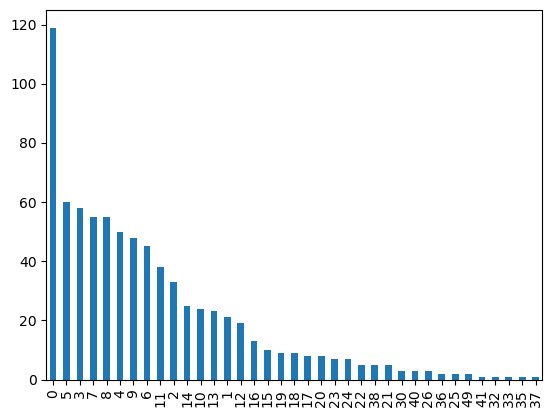

In [6]:
df["years_since_first_symptom"].value_counts().plot(kind="bar")

In [19]:
df.loc[df['years_since_first_symptom'].between(0, 0, 'both'), 'Class'] = '0'
df.loc[df['years_since_first_symptom'].between(0, 5, 'right'), 'Class'] = '1'
df.loc[df['years_since_first_symptom'].between(5, 10, 'right'), 'Class'] = '2'
df.loc[df['years_since_first_symptom'].between(10, 50, 'right'), 'Class'] = '3'
#df.loc[df['years_since_first_symptom'].between(15, 50, 'right'), 'Class'] = '4'

In [20]:
df["Class"].value_counts()

2    227
1    222
3    211
0    119
Name: Class, dtype: int64

<AxesSubplot:>

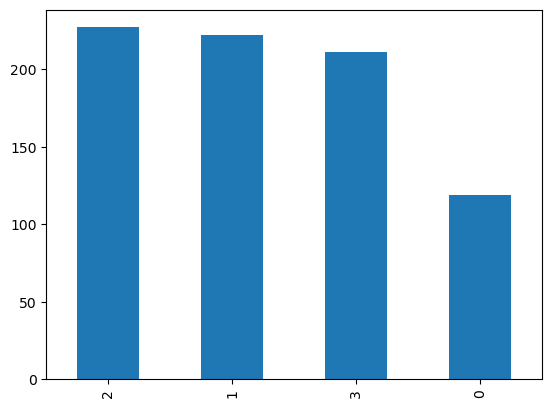

In [21]:
df["Class"].value_counts().plot(kind="bar")

In [22]:
# write the updated DataFrame back to the CSV file
df.to_csv("PVA_features.csv", index=False)

In [ ]:
# define the new data as a dictionary
new_data = pd.read_csv("PVA_test_features.csv")

# read in the existing CSV file as a DataFrame
df = pd.read_csv("PVA_features.csv")

# append the new data to the DataFrame
df = df.append(new_data, ignore_index=True)

# write the updated DataFrame back to the CSV file
df.to_csv("PVA_features.csv", index=False)